In [65]:
import numpy as np
import burst_detector as bd
import pandas as pd
import math
import os
import json
import time
import matplotlib.pyplot as plt
from collections import deque
import distinctipy

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [66]:
params = {}

params["data_filepath"] = "C:/Users/Harris_Lab/Projects/burst-detector/data/neuropixels_dohoung/sc/binary/traces_cached_seg0.raw"
params["KS_folder"] =  "C:/Users/Harris_Lab/Projects/burst-detector/data/neuropixels_dohoung/sc/phy"

params["calc_means"] = True
params["fs"] = 30000
params["n_chan"] = 384
params["pre_samples"] = 20
params["post_samples"] = 62
params["max_spikes"] = 2000

params["skip_cross_sim"] = False

params["jitter"] = False
params["jitter_amt"] = 4
params["sim_thresh"] = 0.6
params["sp_num_thresh"] = 100

params["n_iter"] = 50
params["shuffle_bin_width"] = 0.1
params["window_size"] = 0.025
params["xcorr_bin_width"] = 0.001
params["overlap_tol"] = 10/30000
params["max_window"] = 0.025
params["min_xcorr_rate"] = 800

params["xcorr_ref_p"] = 0.0005
params["ref_pers"] = [0.002]
params["max_viol"] = 0.01

params["xcorr_coeff"] =  0.5
params["ref_pen_coeff"] = 1
params["final_thresh"] = 0.7
params["max_dist"] = 10

In [67]:
times = np.load(os.path.join(params['KS_folder'], 'spike_times.npy')).flatten()
clusters = np.load(os.path.join(params['KS_folder'], 'spike_clusters.npy')).flatten() 
n_clust = clusters.max() + 1
counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv(os.path.join(params['KS_folder'], 'cluster_group.tsv'), sep="\t")
channel_pos = np.load(os.path.join(params['KS_folder'], "channel_positions.npy"))

In [68]:
rawData = np.memmap(params['data_filepath'], dtype='float32', mode='r')
data = np.reshape(rawData, (int(rawData.size/params['n_chan']), params['n_chan']))
mean_wf = None

In [69]:
cl_good = np.zeros(n_clust, dtype=bool)
unique = np.unique(clusters)
for i in range(n_clust):
     if (i in unique) and (counts[i] > params['sp_num_thresh']) \
        and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
            cl_good[i] = True

In [70]:
cl_good.sum()

308

In [71]:
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

mean_sim, offset, wf_norms, mean_wf, pass_ms = bd.stages.calc_mean_sim(
        data, 
        times_multi, 
        clusters, 
        counts, 
        n_clust,
        labels,
        mean_wf,
        params
)
print("Found %d candidate cluster pairs" % (pass_ms.sum()/2))

Found 47 candidate cluster pairs


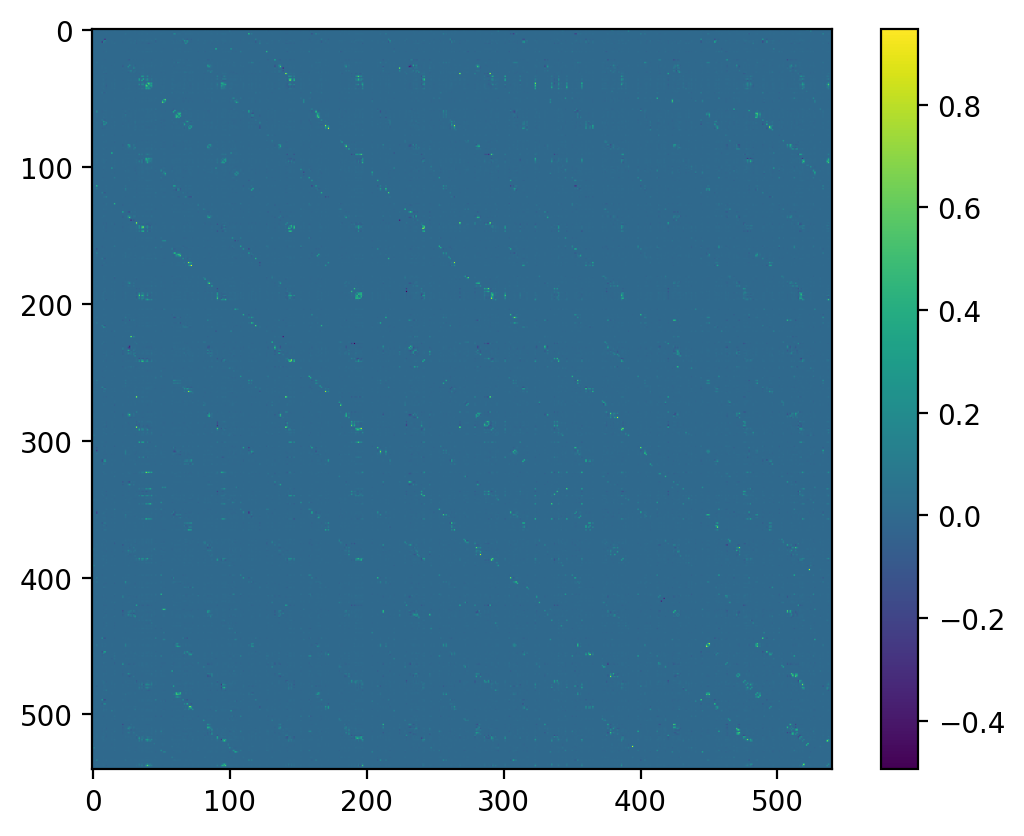

In [72]:
plt.imshow(mean_sim); plt.colorbar()

In [21]:
if not params['skip_cross_sim']:
        print("Pre-fetching spikes for cross-projection...")
        # pre-fetch spikes and free data RAM
        spikes = {}
        num = 0
        for c1 in range(n_clust):
            for c2 in range(c1+1, n_clust):
                if pass_ms[c1,c2]:
                    num += 1

                    if c1 not in spikes:
                        spikes[c1] = bd.extract_spikes(
                            data, 
                            times_multi, 
                            clusters, 
                            c1, 
                            pre_samples=params['pre_samples'],
                            post_samples=params['post_samples'],
                            n_chan=params['n_chan'],
                            max_spikes=params['max_spikes']
                        )
                    if c2 not in spikes:
                        spikes[c2] = bd.extract_spikes(
                            data, 
                            times_multi, 
                            clusters, 
                            c2, 
                            pre_samples=params['pre_samples'],
                            post_samples=params['post_samples'],
                            n_chan=params['n_chan'],
                            max_spikes=params['max_spikes']
                        )
        data = None


Pre-fetching spikes for cross-projection...


In [109]:
cross_sim = bd.stages.calc_cross_sim(spikes, offset, mean_wf, wf_norms, pass_ms, n_clust)
spikes = None

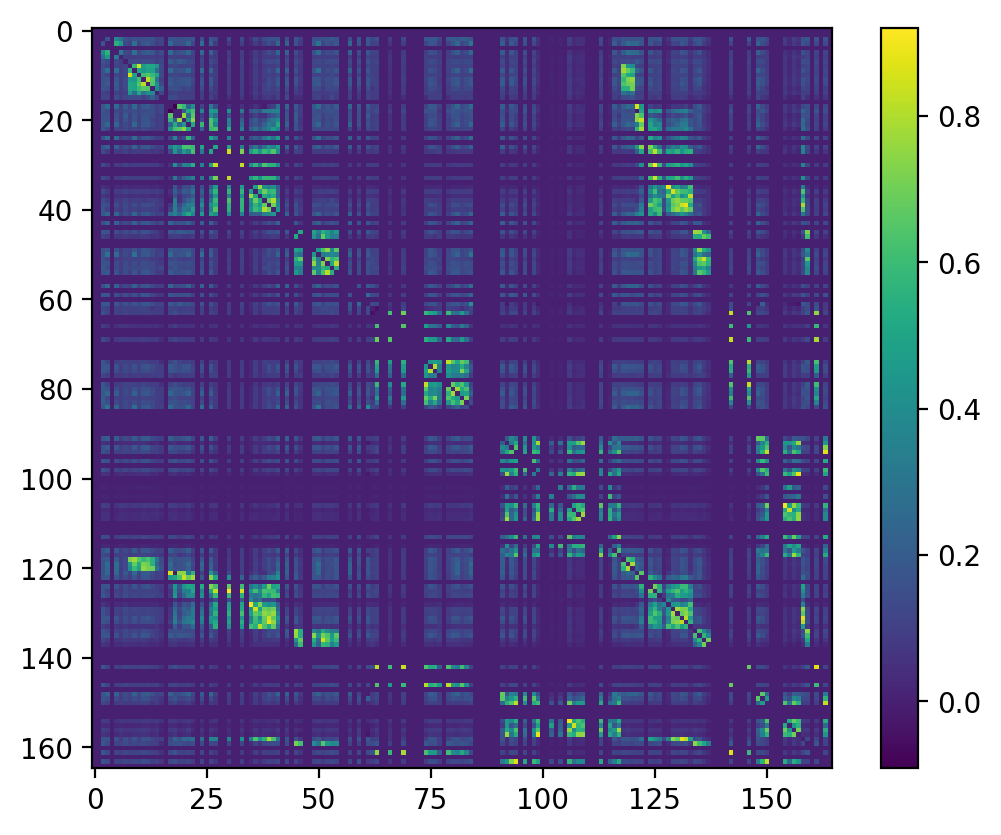

In [10]:
plt.imshow(mean_sim); plt.colorbar()

In [22]:
spikes[3].shape

(2000, 385, 82)

In [25]:
spikes[3][:, 0, :].shape

(2000, 82)

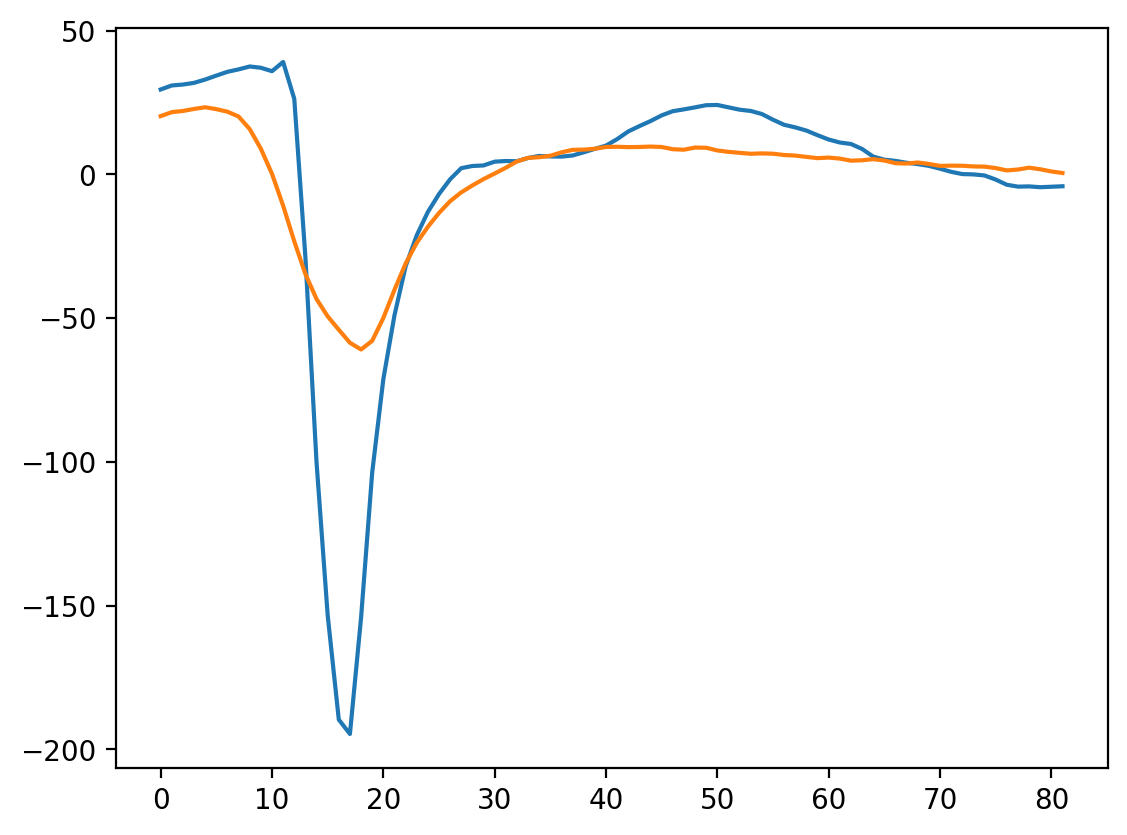

In [35]:
plt.plot(mean_wf[6,0],);
plt.plot(mean_wf[3,0],);

In [255]:
if not params['skip_cross_sim']:
        print("Pre-fetching spikes for cross-projection...")
        # pre-fetch spikes and free data RAM
        spikes = {}
        num = 0
        for c1 in range(n_clust):
            for c2 in range(c1+1, n_clust):
                if pass_ms[c1,c2]:
                    num += 1

                    if c1 not in spikes:
                        spikes[c1] = bd.extract_spikes(
                            data, 
                            times_multi, 
                            clusters, 
                            c1, 
                            pre_samples=params['pre_samples'],
                            post_samples=params['post_samples'],
                            n_chan=params['n_chan'],
                            max_spikes=params['max_spikes']
                        )
                    if c2 not in spikes:
                        spikes[c2] = bd.extract_spikes(
                            data, 
                            times_multi, 
                            clusters, 
                            c2, 
                            pre_samples=params['pre_samples'],
                            post_samples=params['post_samples'],
                            n_chan=params['n_chan'],
                            max_spikes=params['max_spikes']
                        )
        data = None


Pre-fetching spikes for cross-projection...


In [256]:
cross_sim = bd.stages.calc_cross_sim(spikes, offset, mean_wf, wf_norms, pass_ms, n_clust)
spikes = None

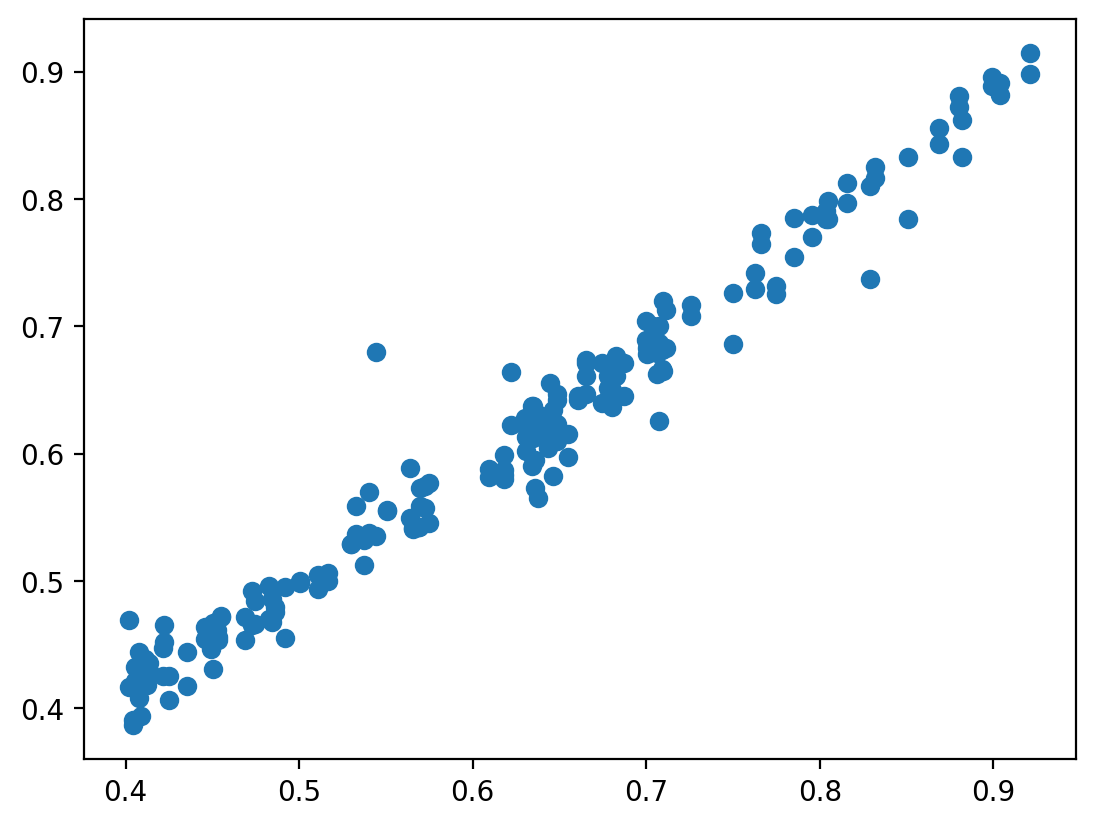

In [39]:
plt.scatter(mean_sim.flatten()[cross_sim.flatten() != 0], cross_sim.flatten()[cross_sim.flatten() != 0])

In [6]:
xcorr_sig, xgrams, shfl_xgrams = bd.stages.calc_xcorr_metric(
        times, 
        clusters,
        n_clust, 
        pass_ms, 
        params
)

In [7]:
ref_pen, ref_per = bd.stages.calc_ref_p(times, clusters, n_clust, pass_ms, xcorr_sig,\
                                   params)

In [8]:
mean_sim[pass_ms == False] = 0

In [9]:
final_metric = np.zeros_like(mean_sim)
    
for c1 in range(n_clust):
    for c2 in range(c1, n_clust):
        met = np.sqrt(mean_sim[c1,c2] * mean_sim[c2,c1]) + \
        params['xcorr_coeff']*xcorr_sig[c1,c2] - \
        params['ref_pen_coeff']*ref_pen[c1,c2]

        final_metric[c1,c2] = max(met, 0)
        final_metric[c2,c1] = max(met, 0)

In [10]:
old2new, new2old = bd.stages.merge_clusters(clusters, counts, mean_wf, final_metric, params)

In [11]:
merges = list(new2old.values())

In [13]:
merges

[[113, 111],
 [139, 121, 106],
 [116, 103, 137],
 [109, 120],
 [94, 96],
 [124, 126, 125],
 [24, 25],
 [102, 88, 98],
 [23, 20],
 [135, 51]]

In [14]:
for merge in merges:
    merge.sort()
    print(merge)

[111, 113]
[106, 121, 139]
[103, 116, 137]
[109, 120]
[94, 96]
[124, 125, 126]
[24, 25]
[88, 98, 102]
[20, 23]
[51, 135]


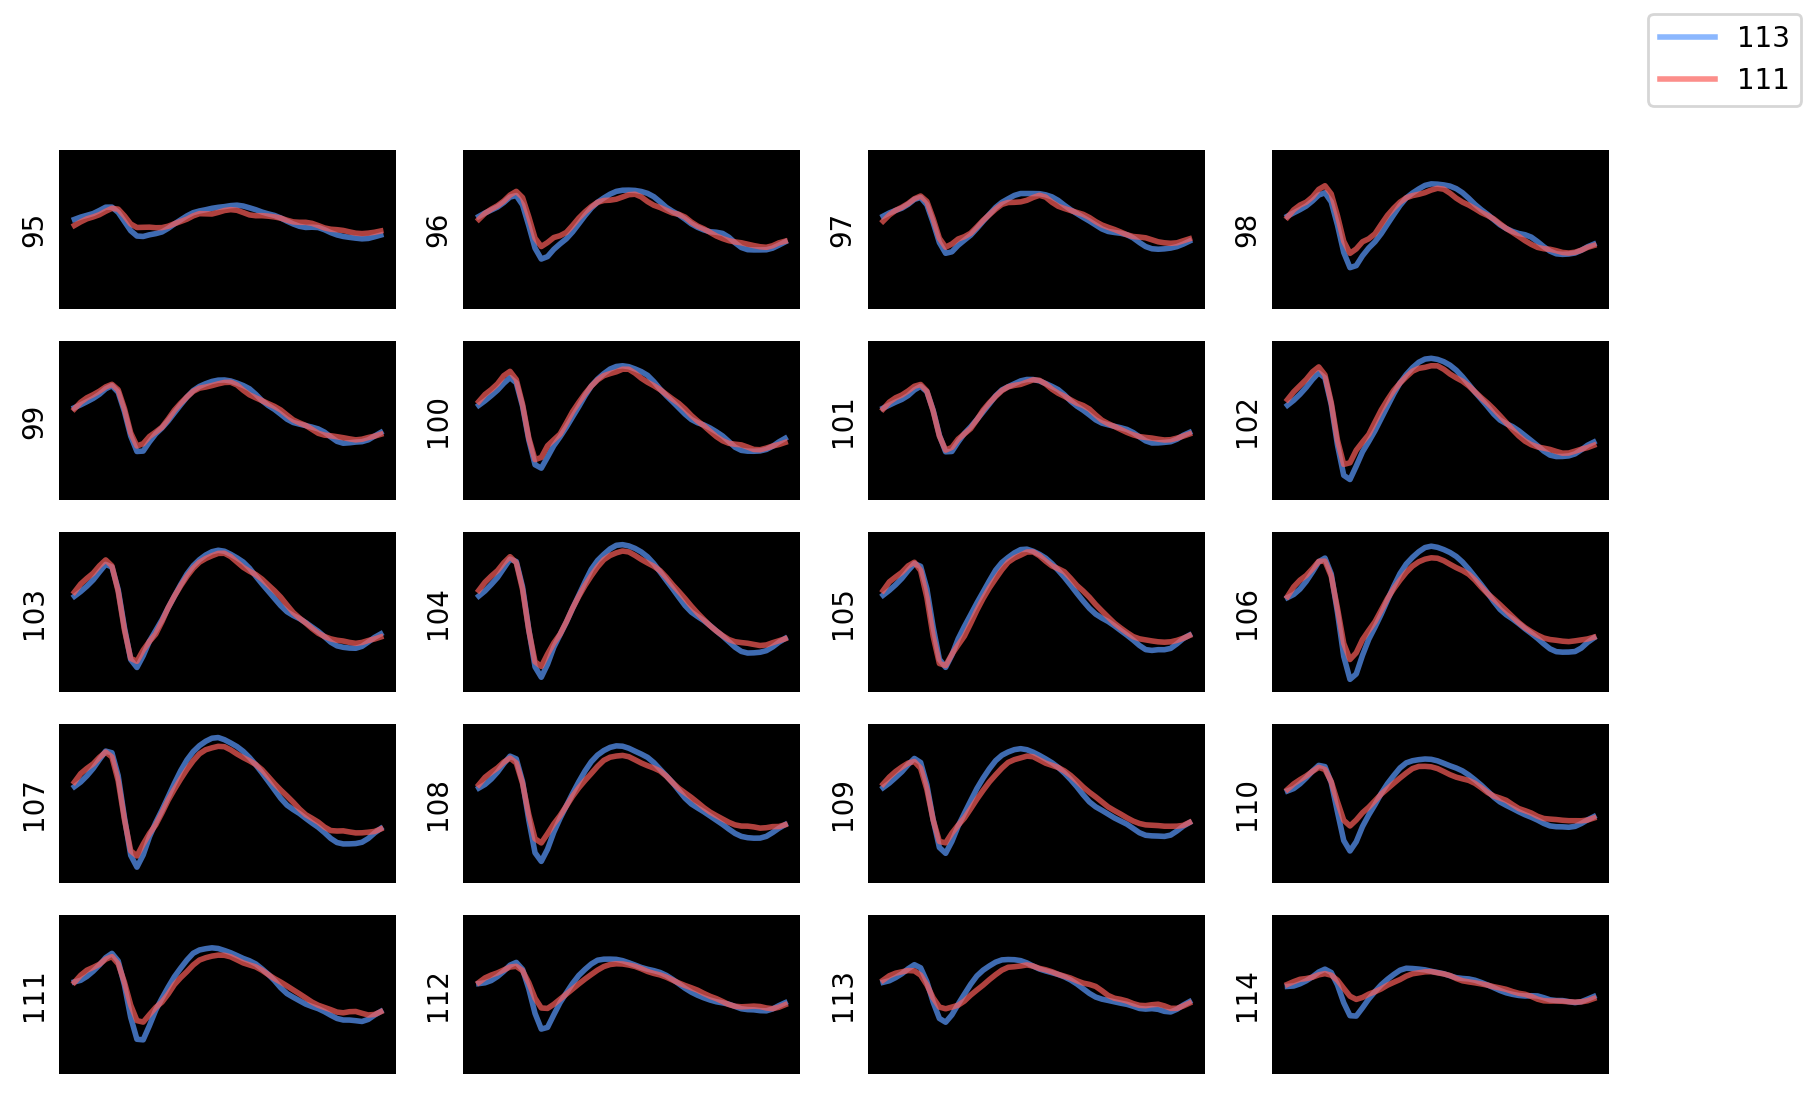

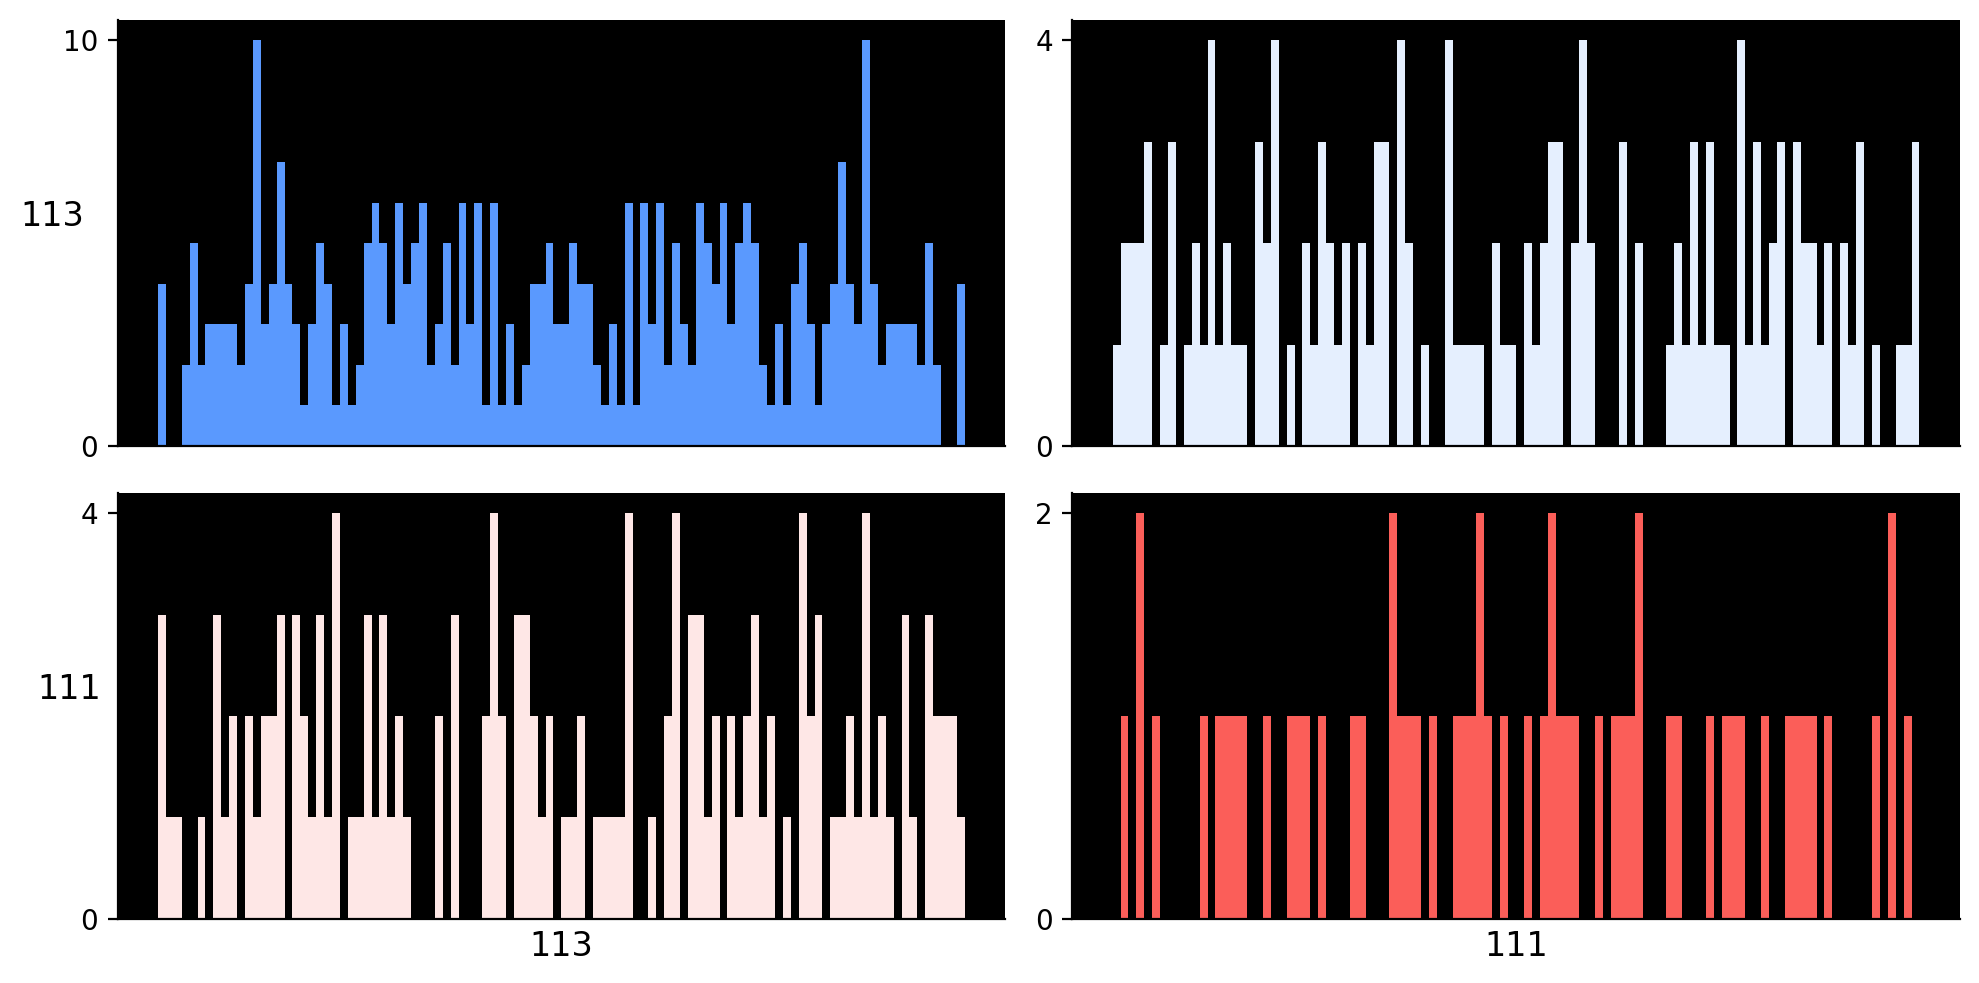

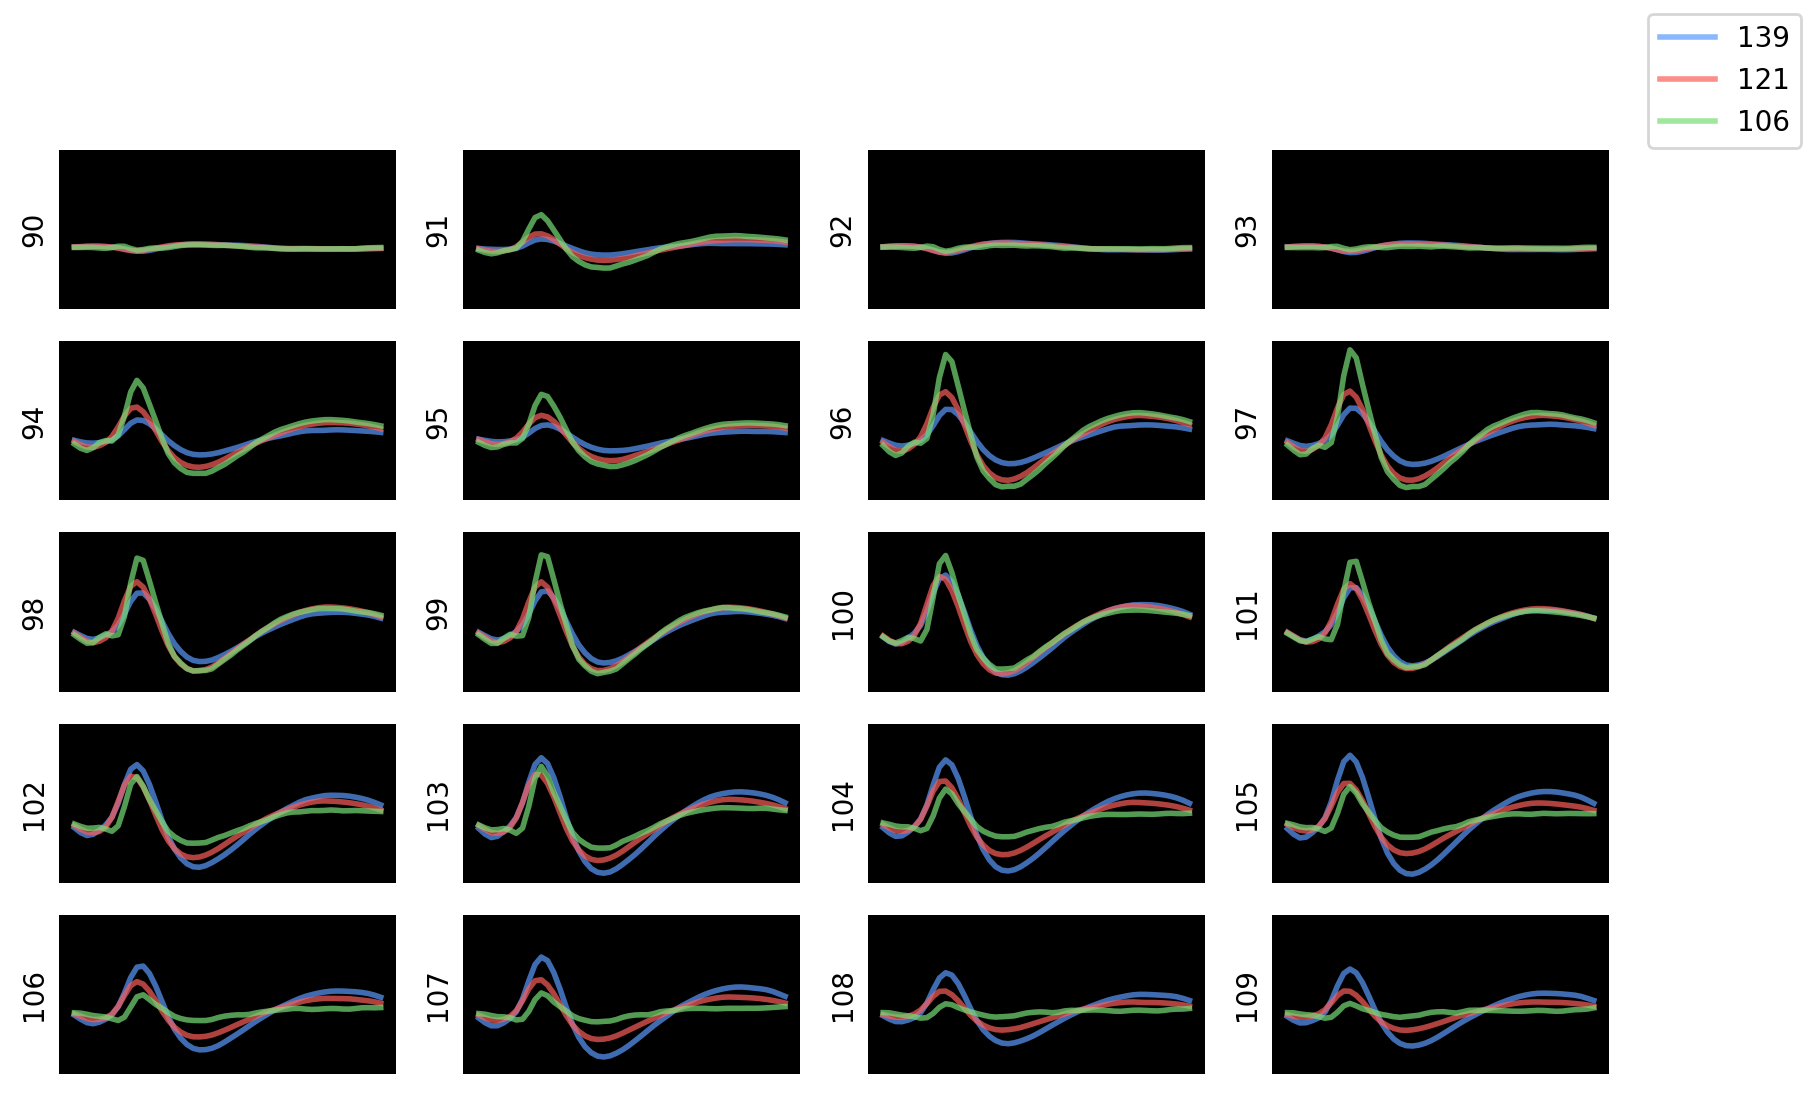

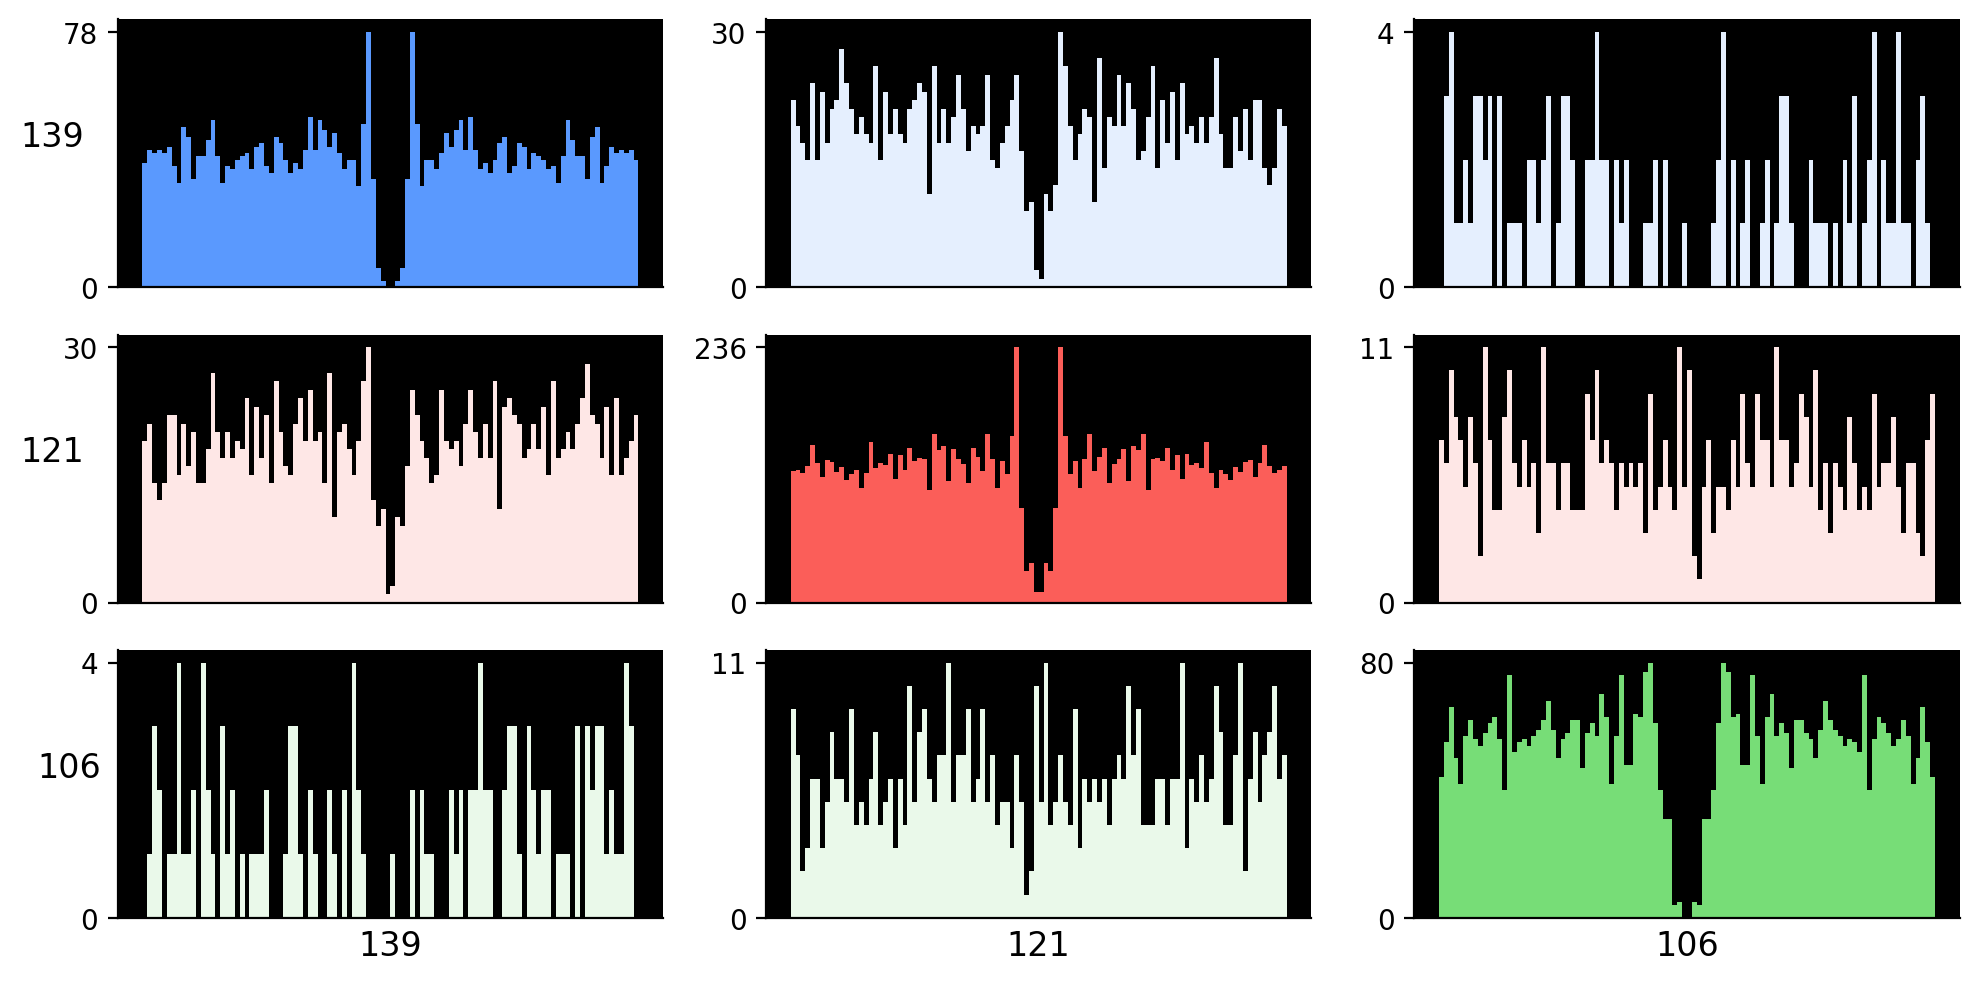

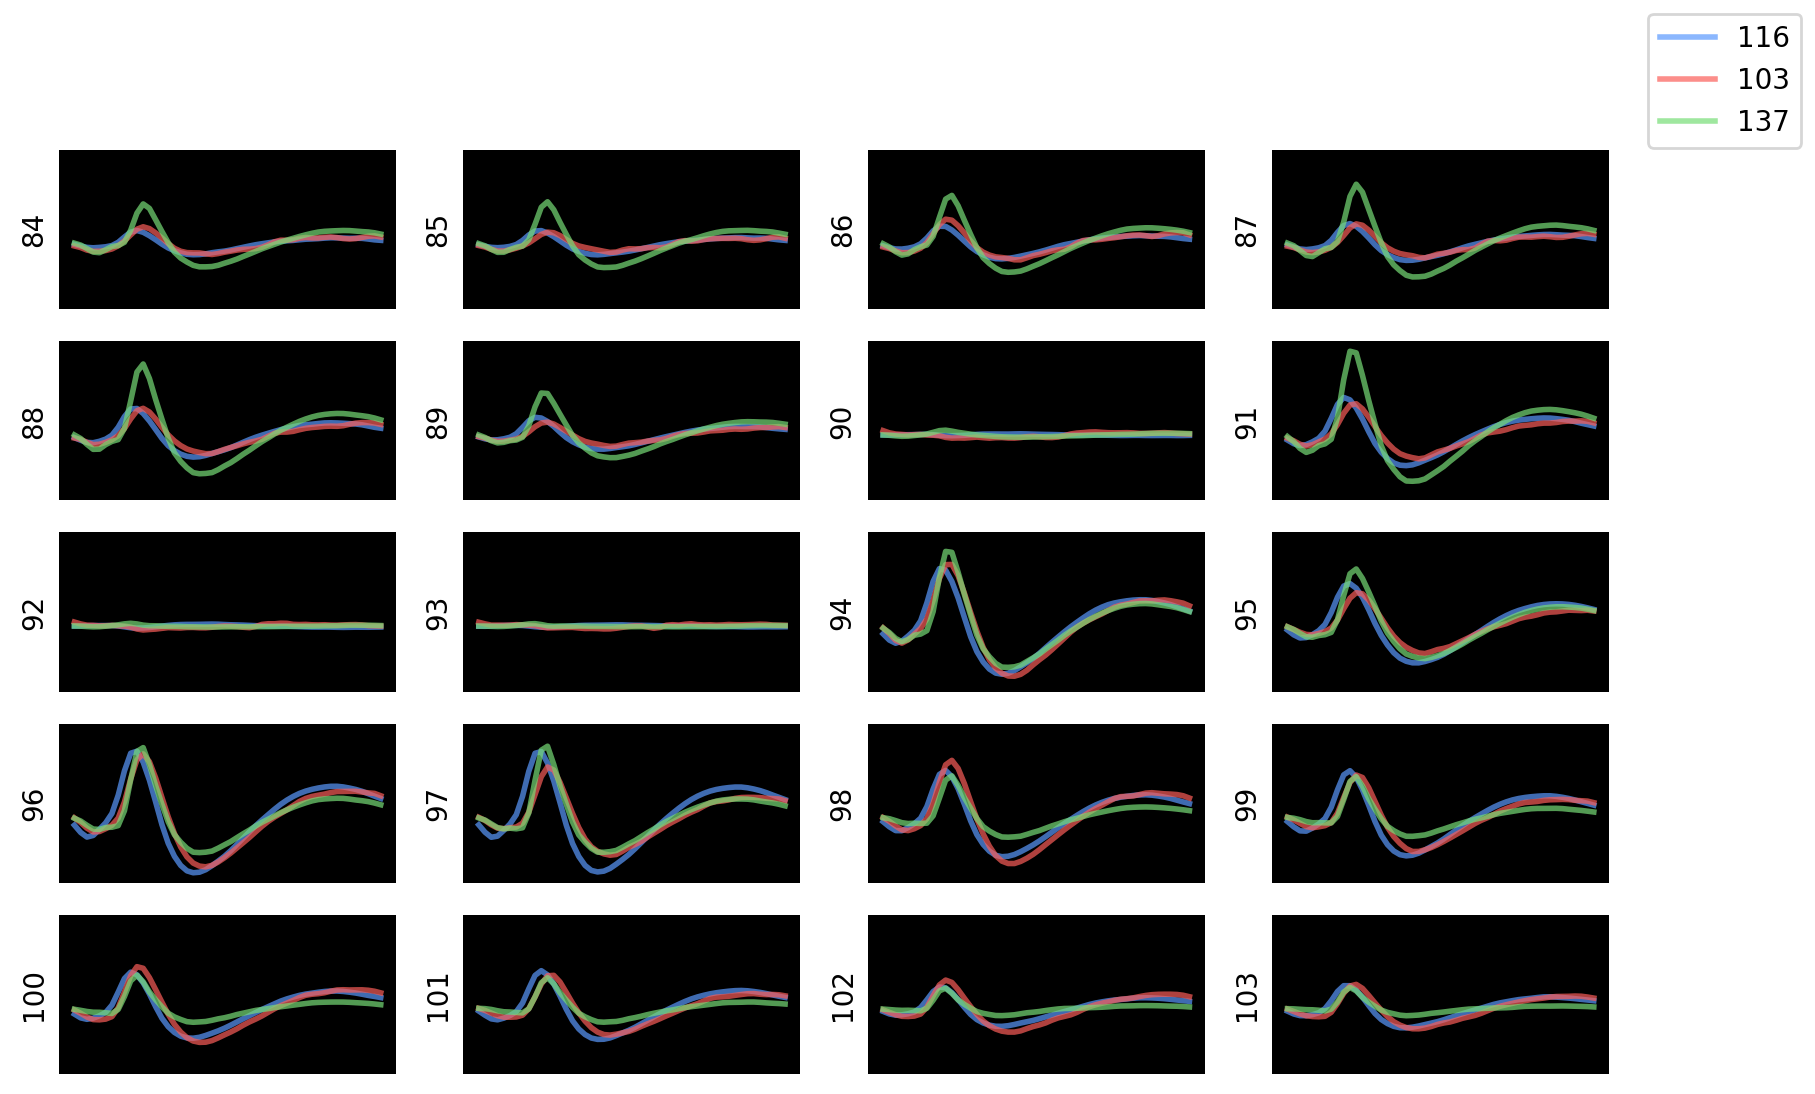

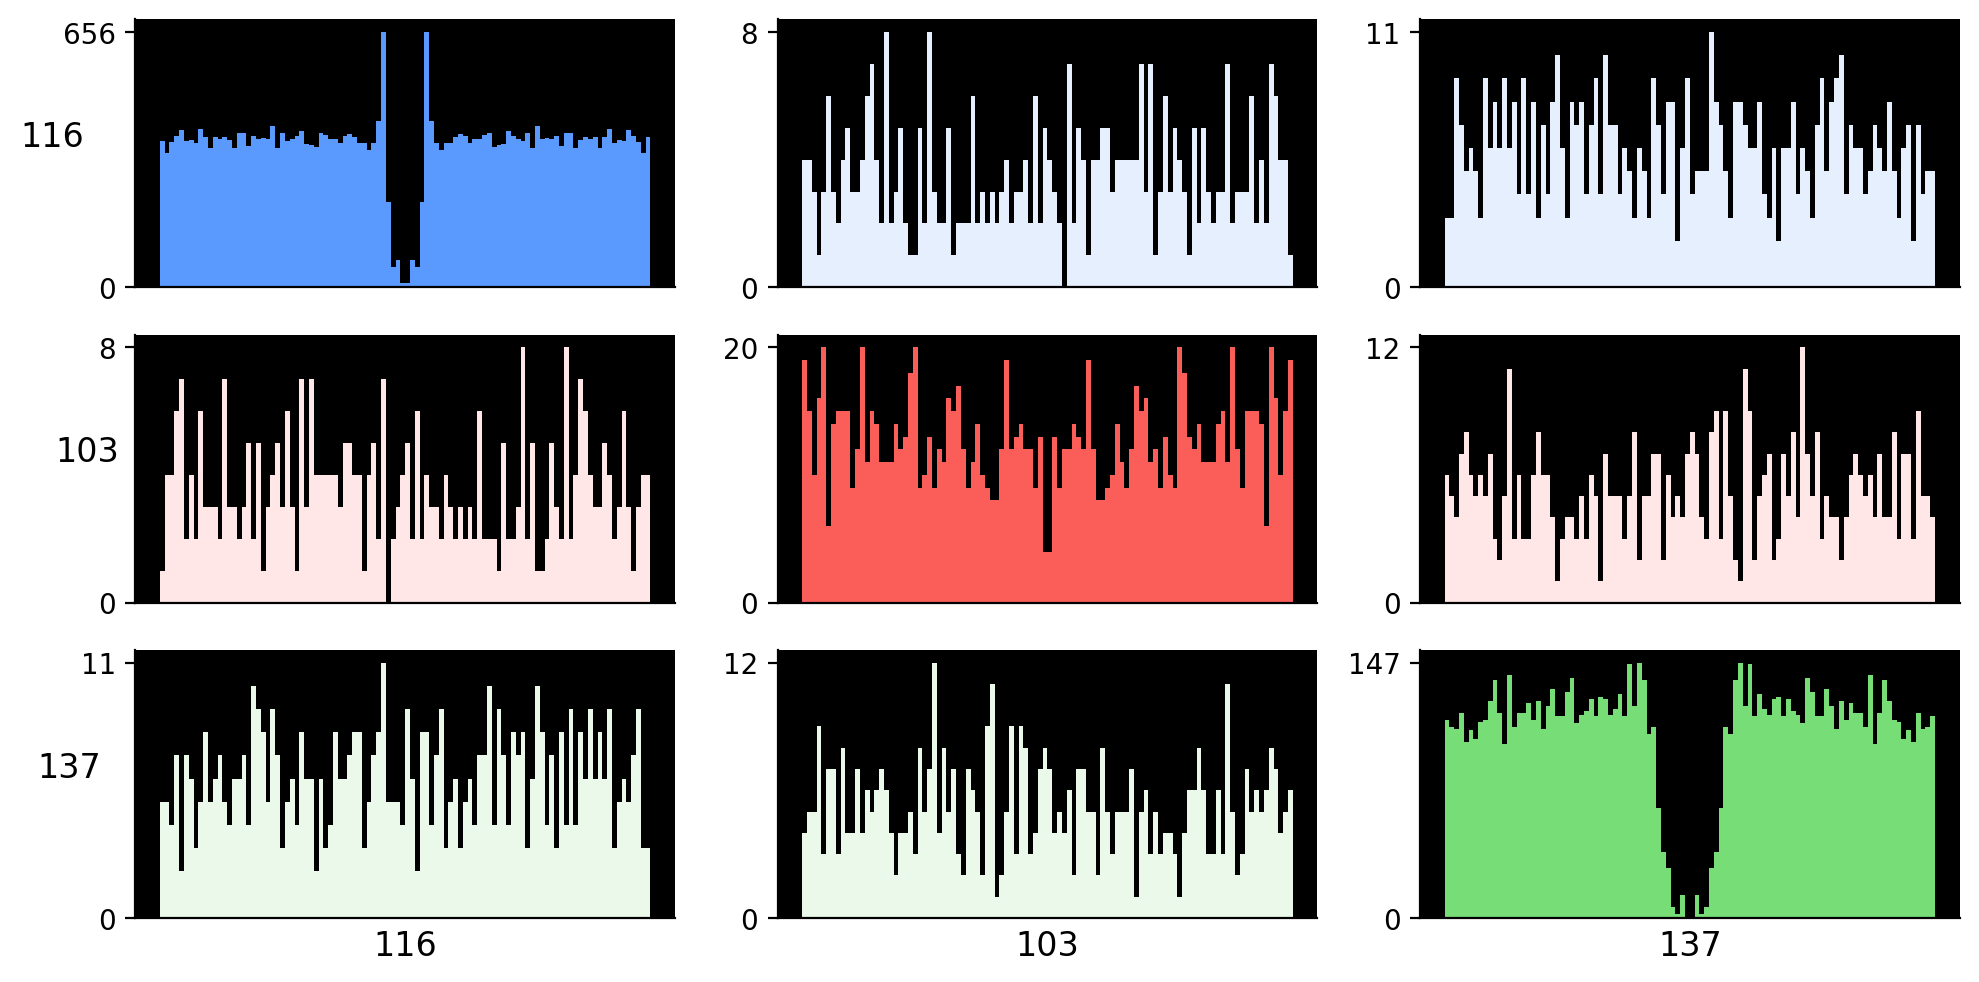

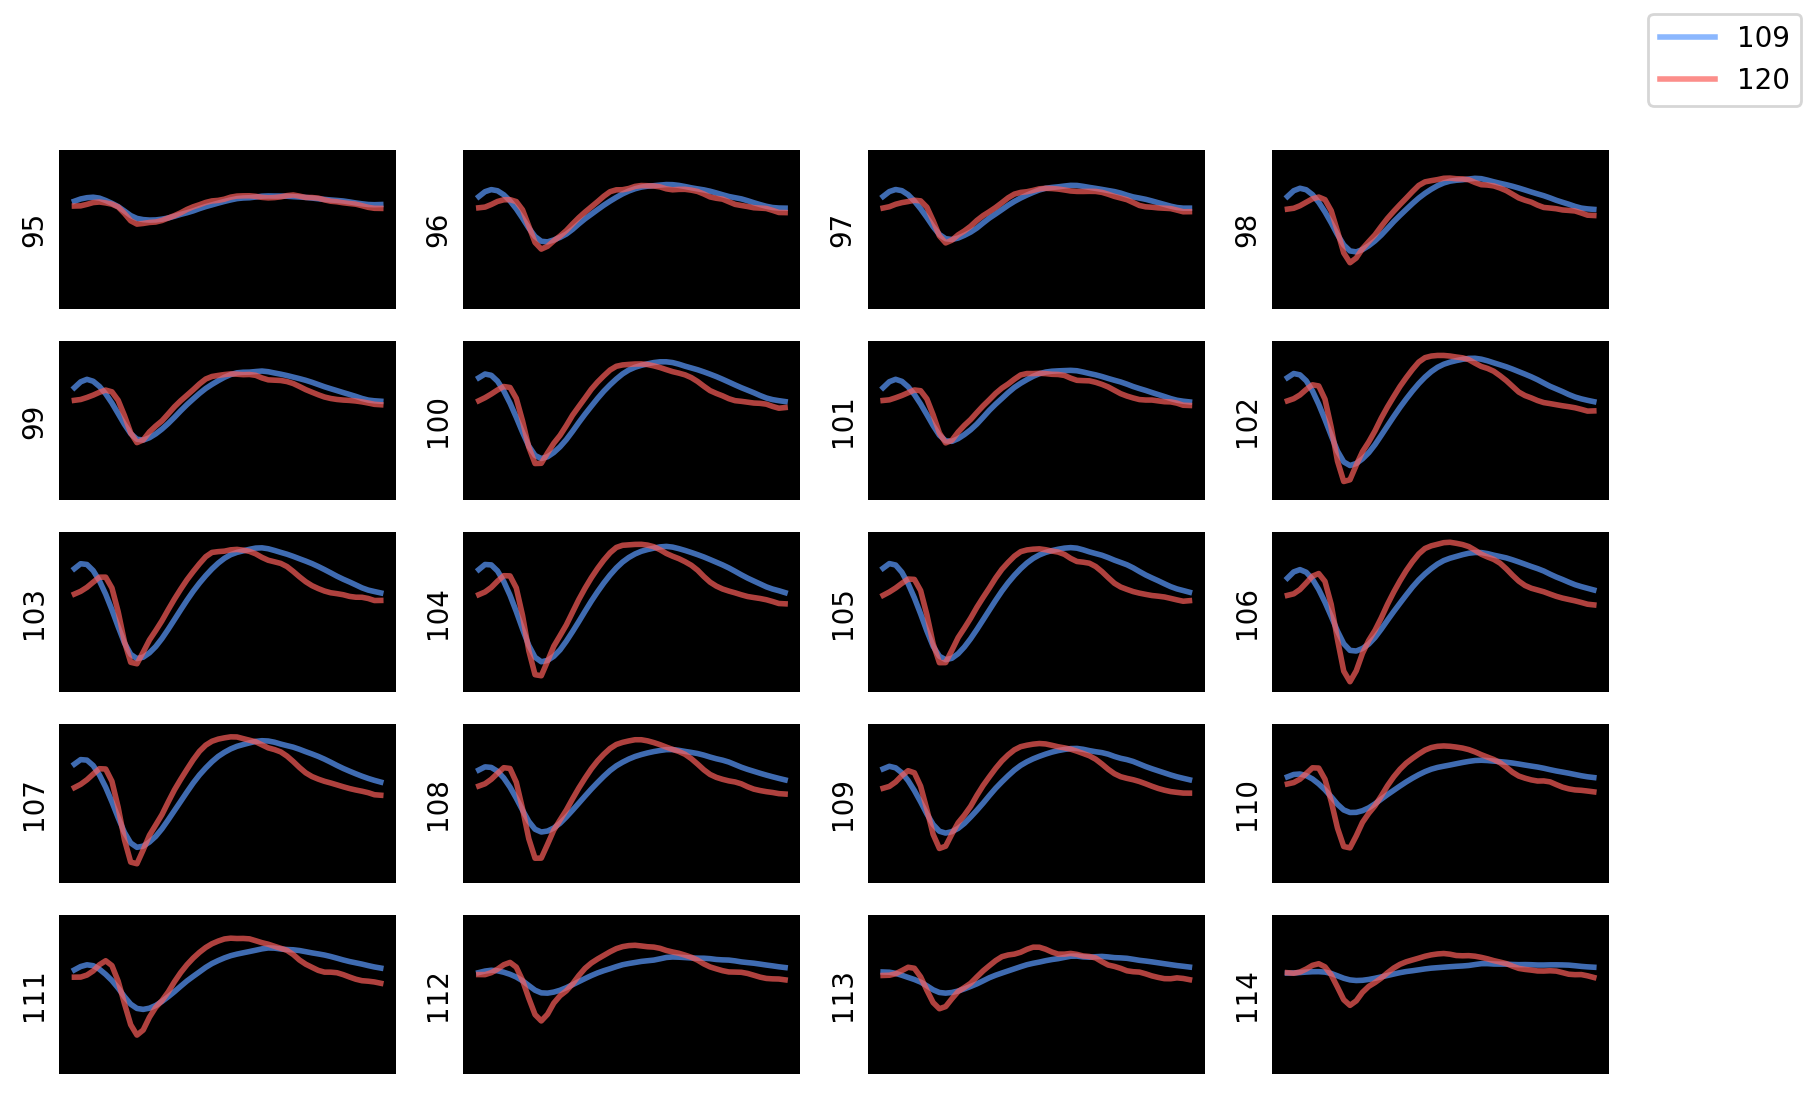

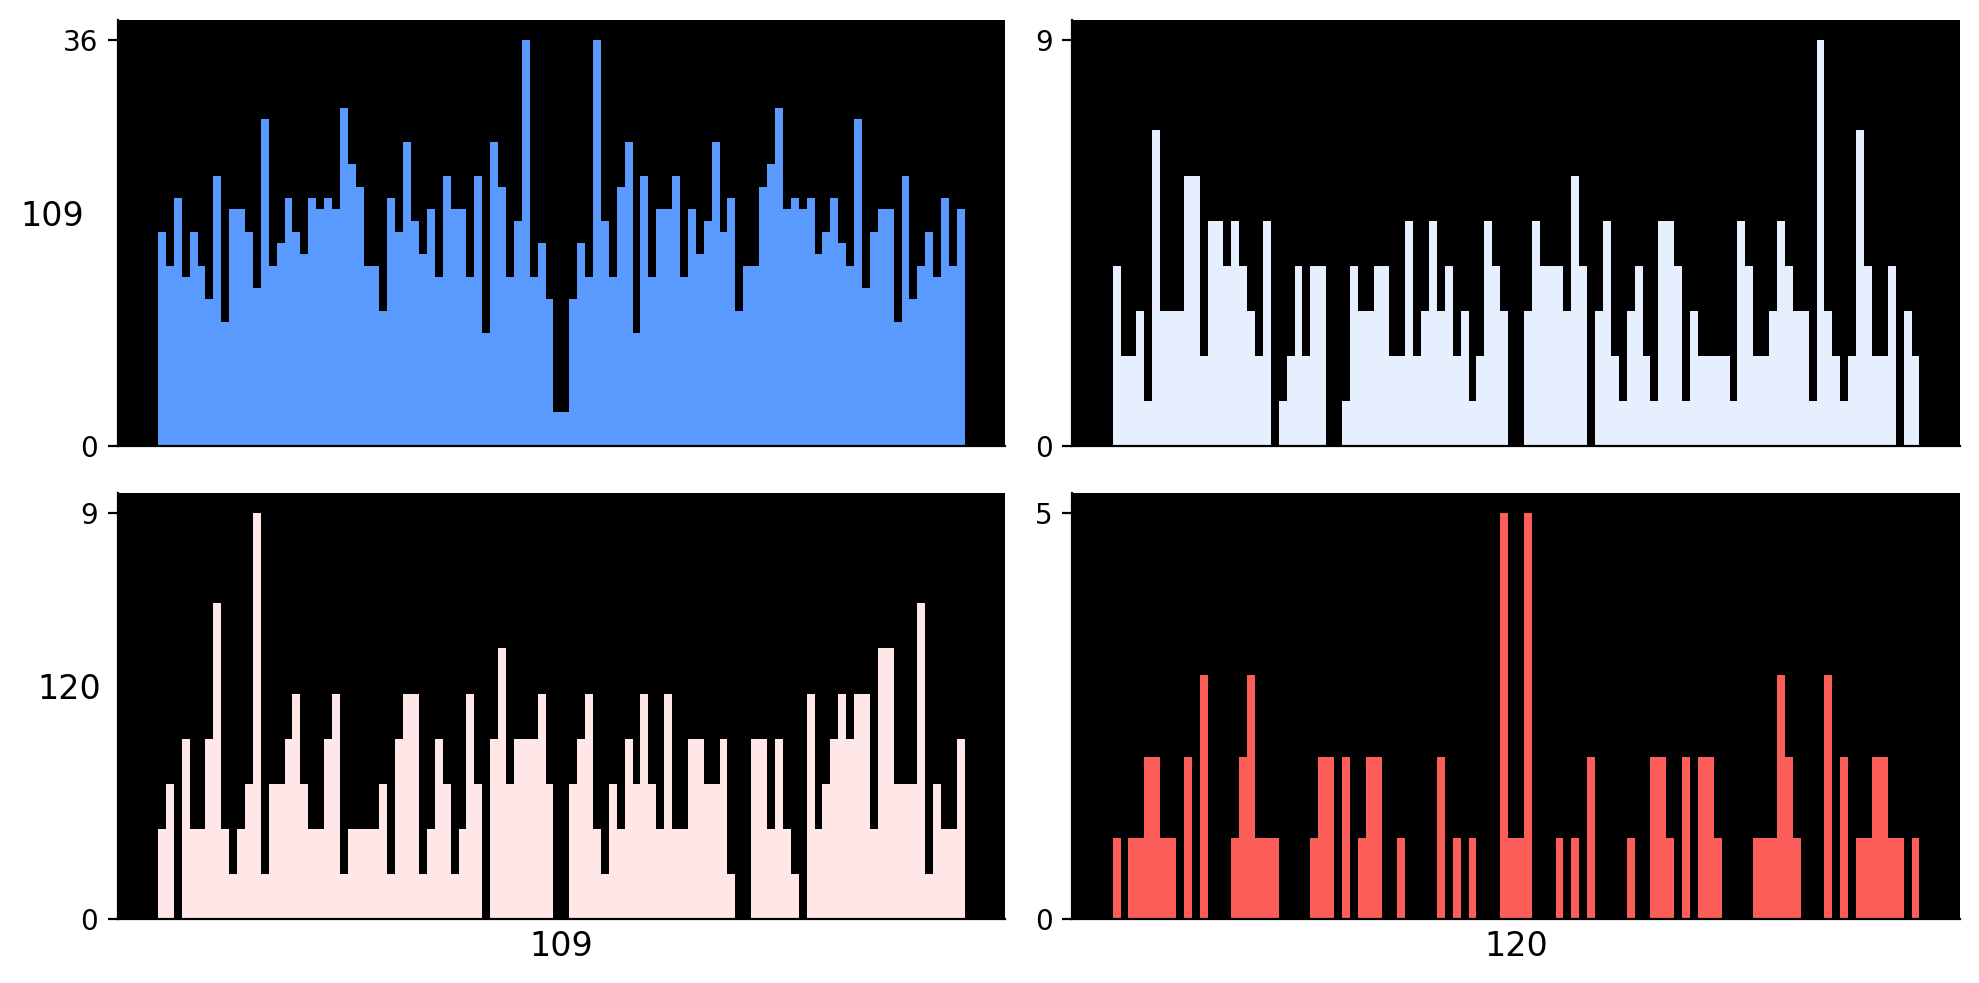

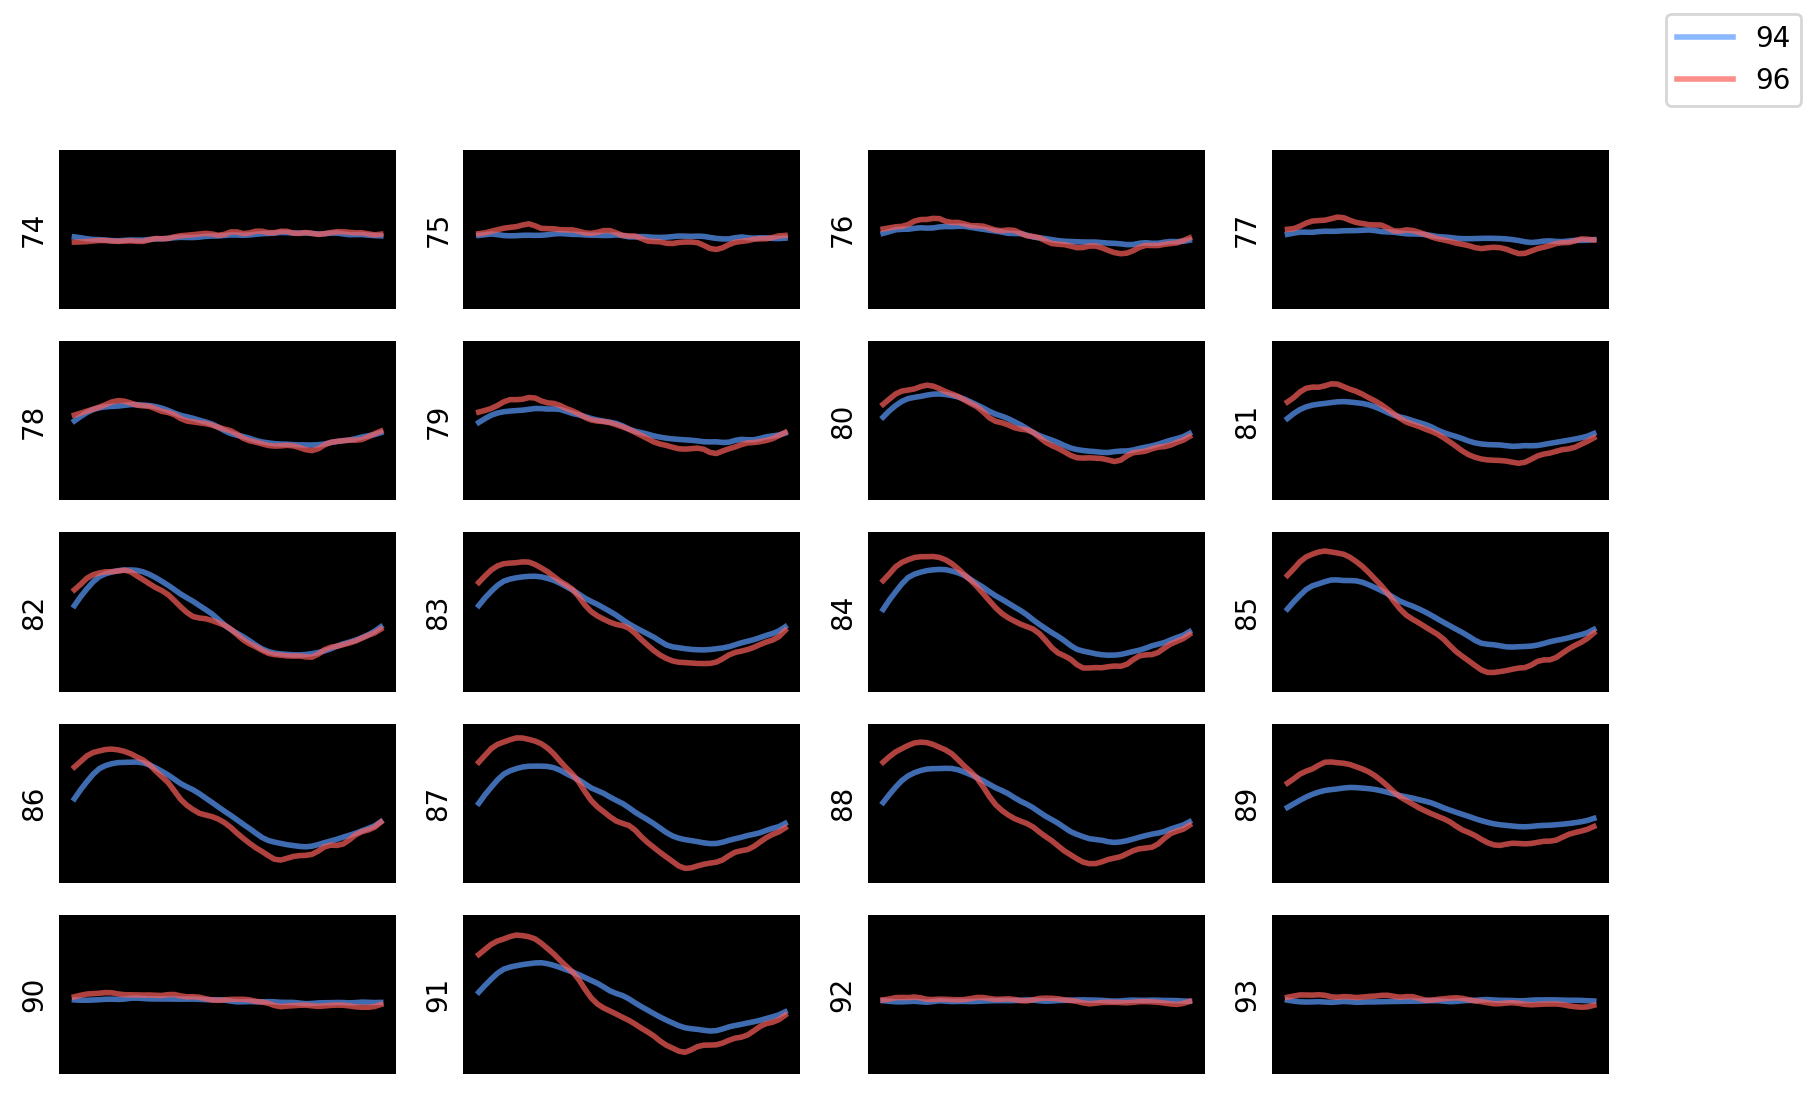

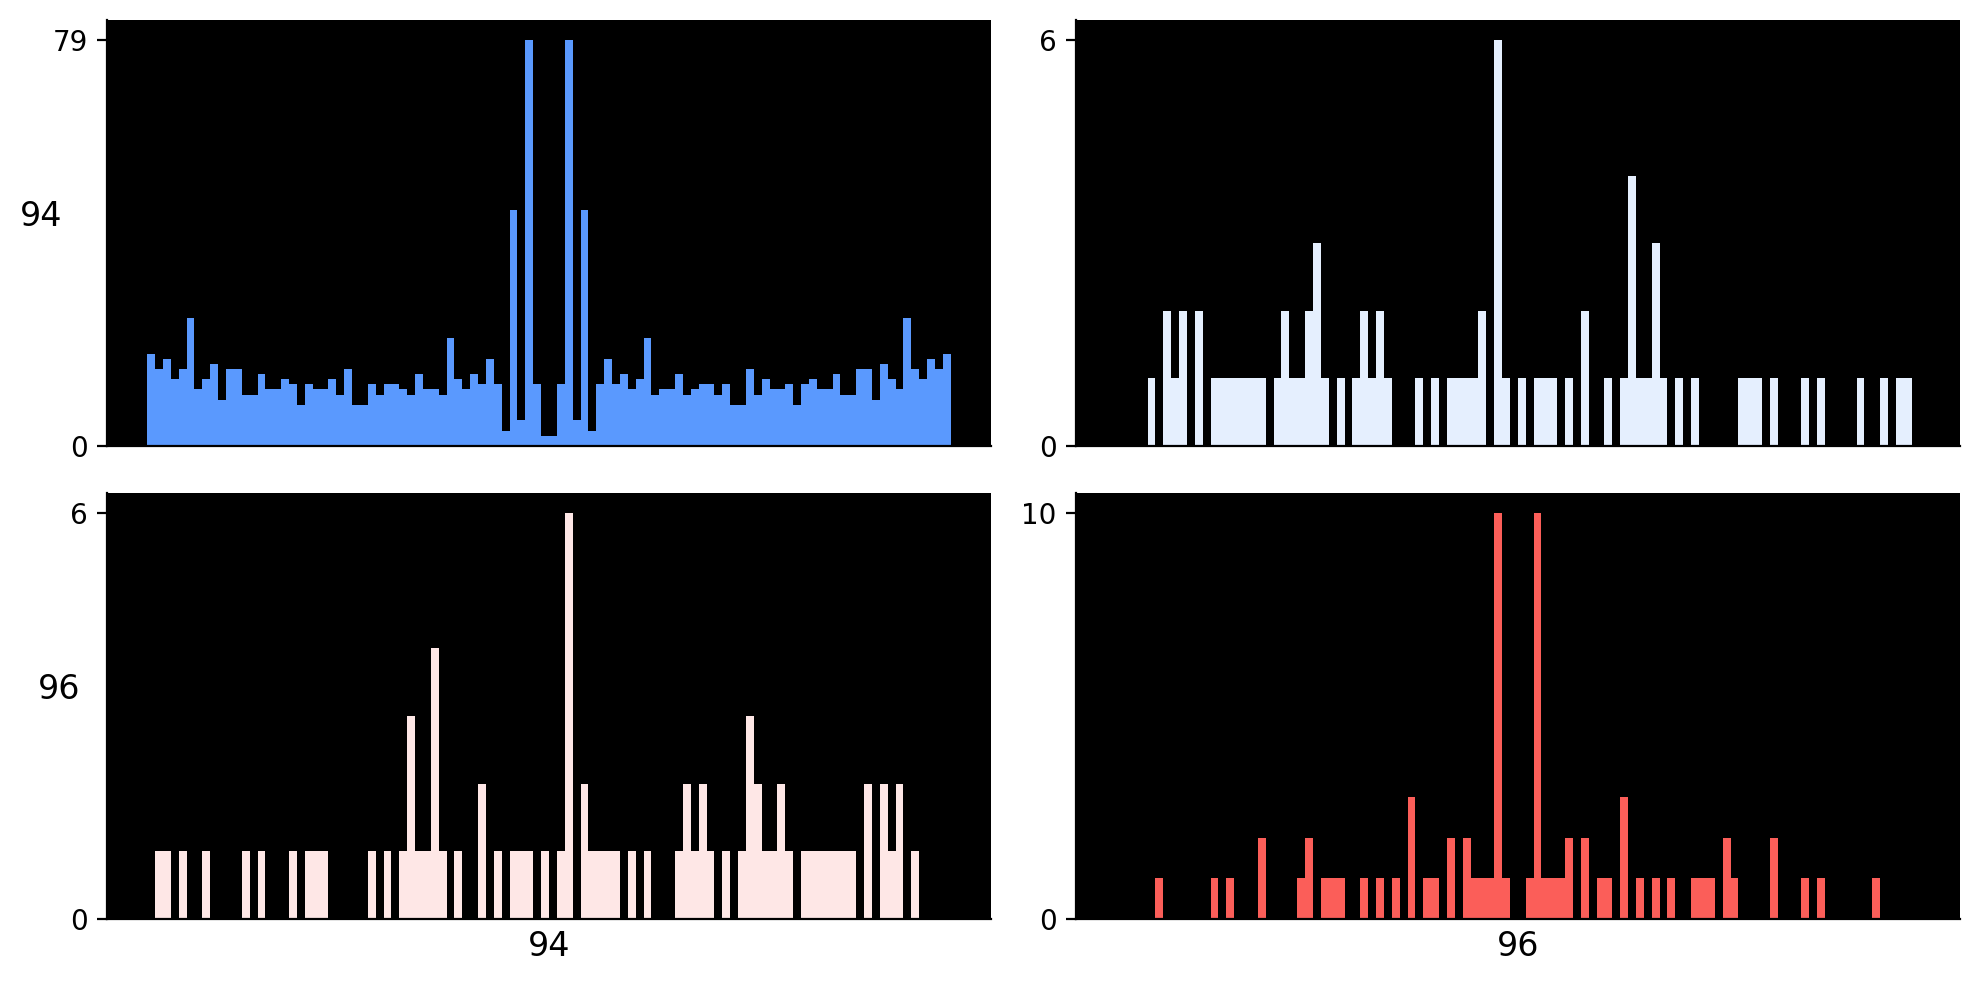

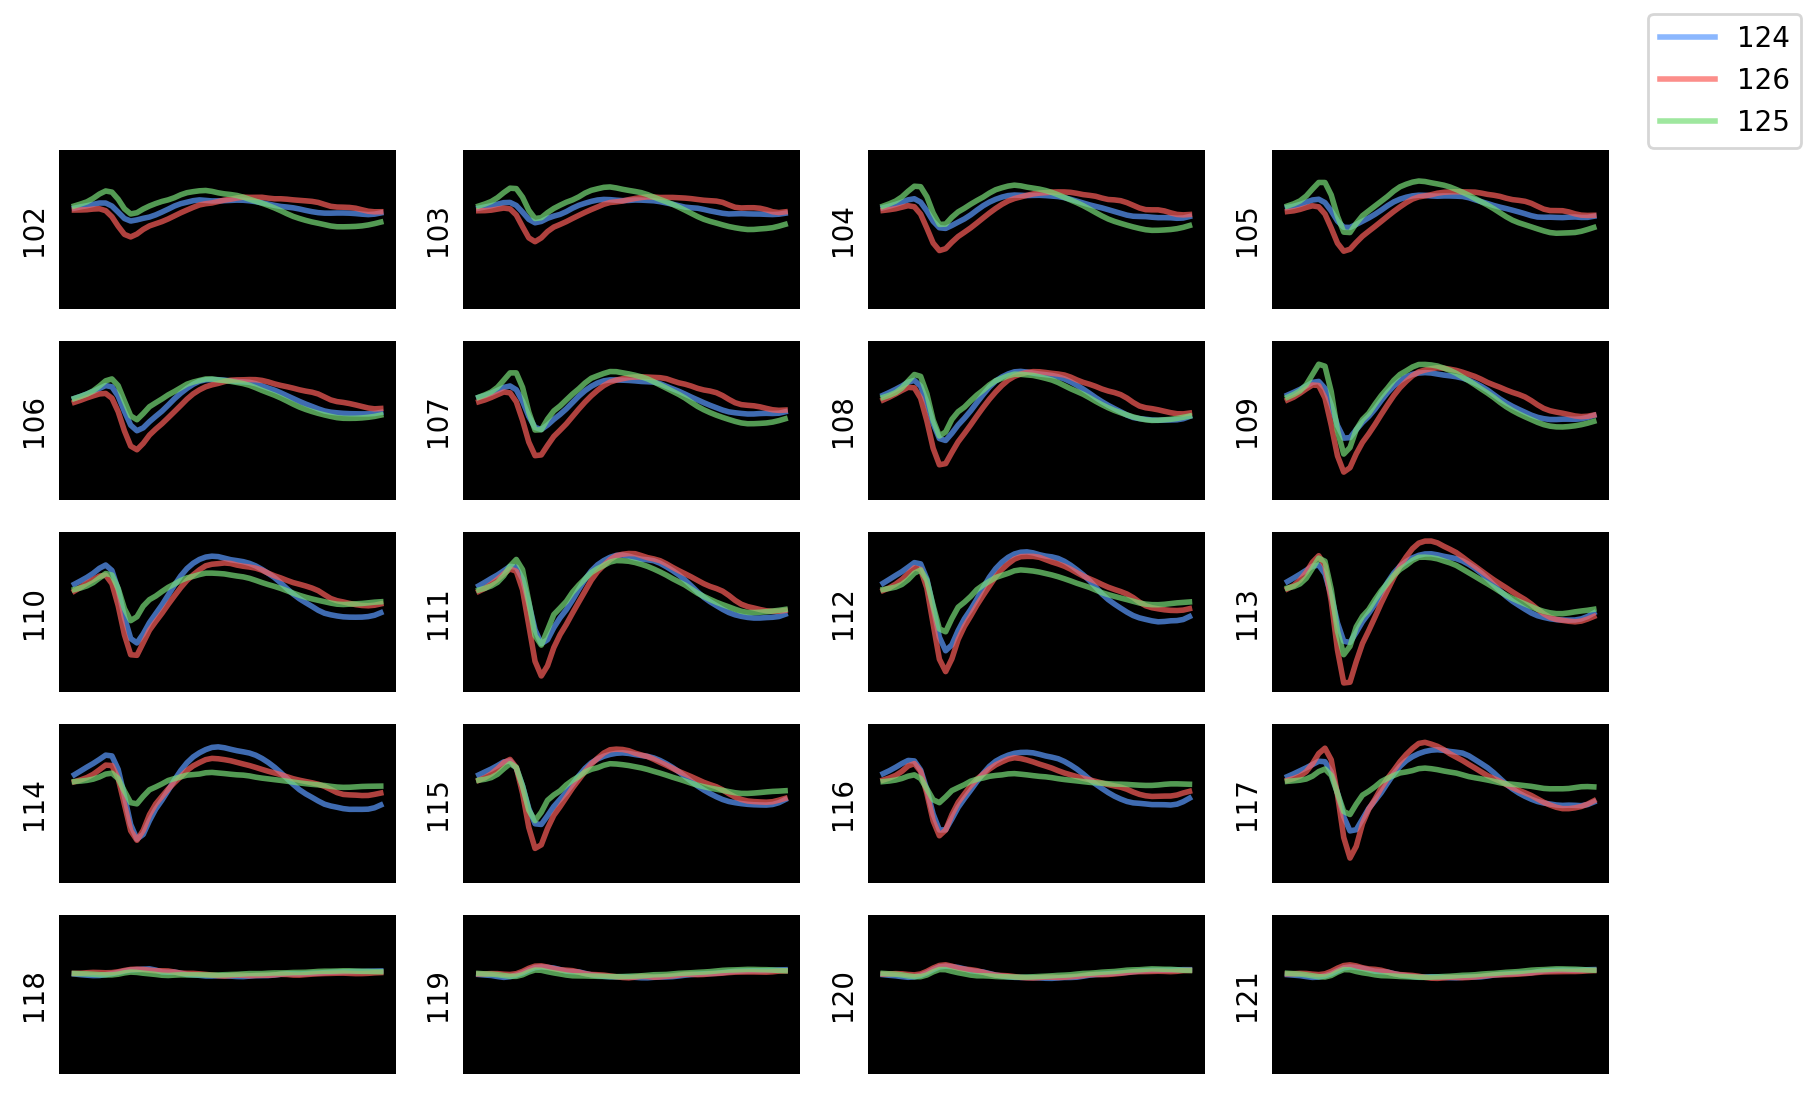

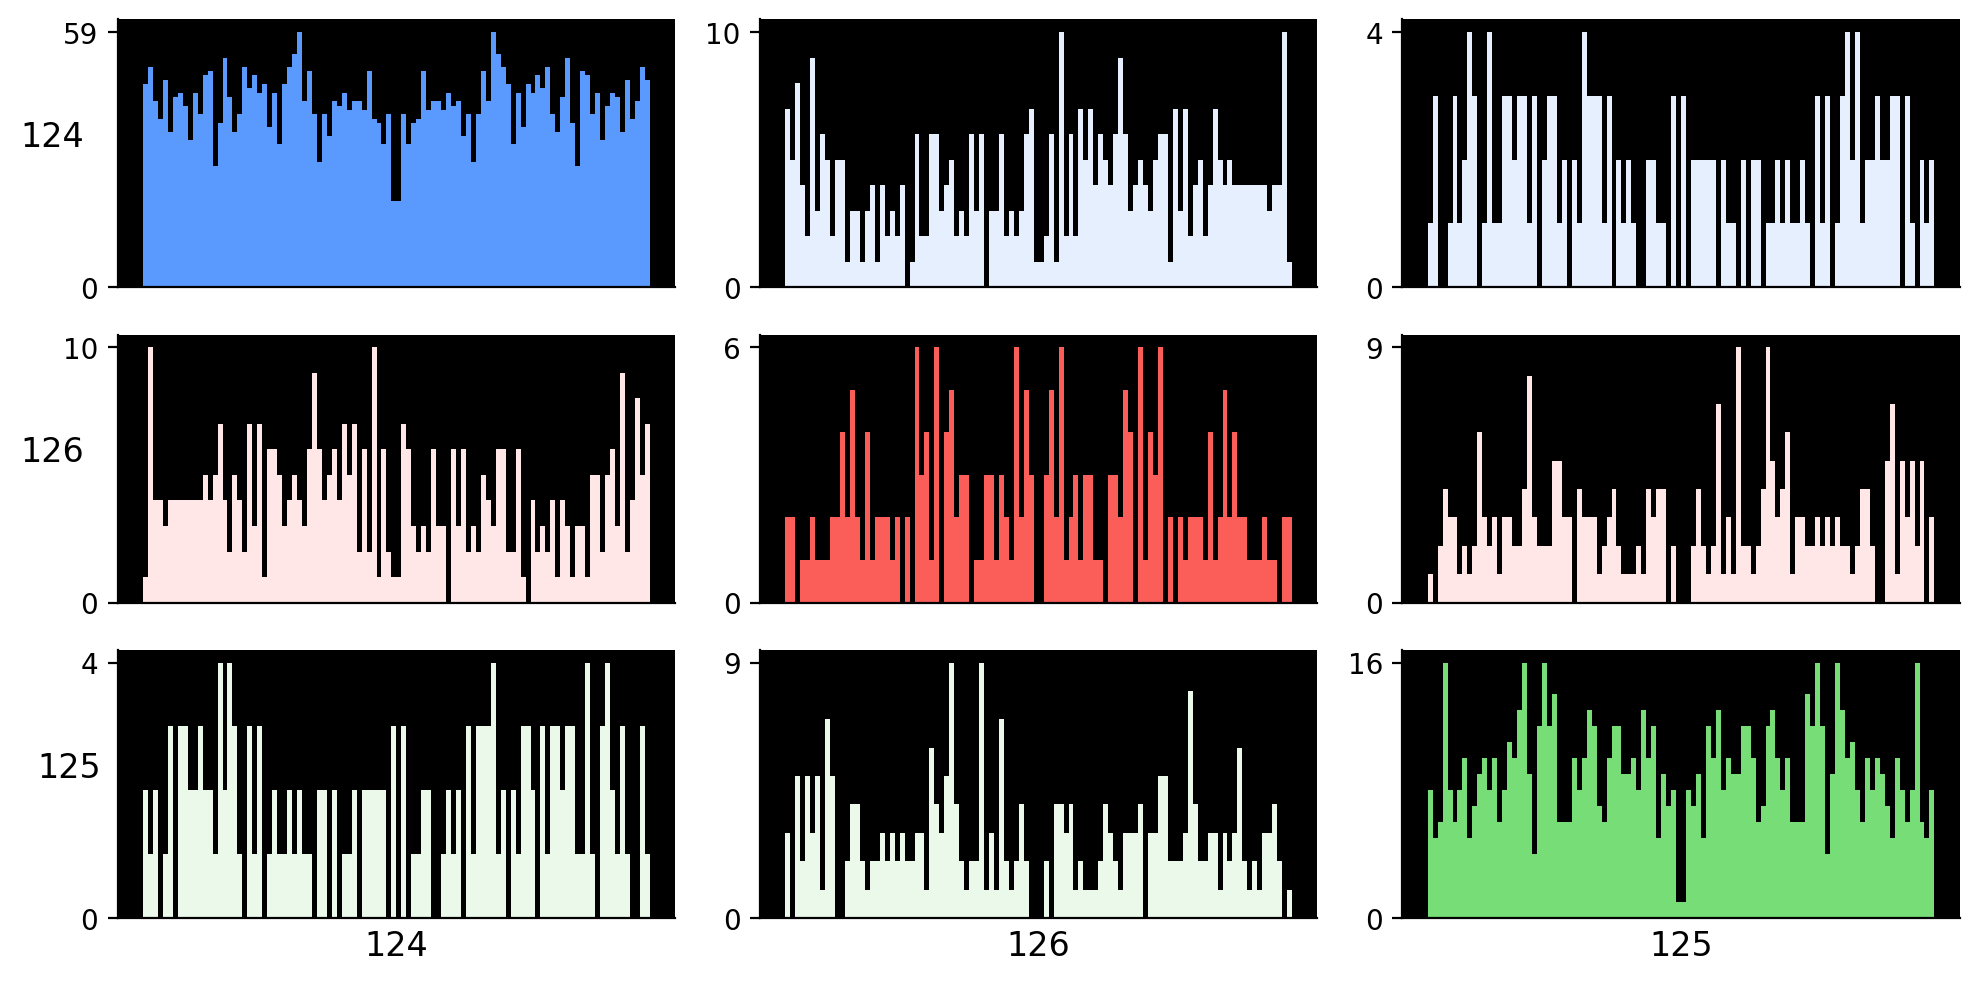

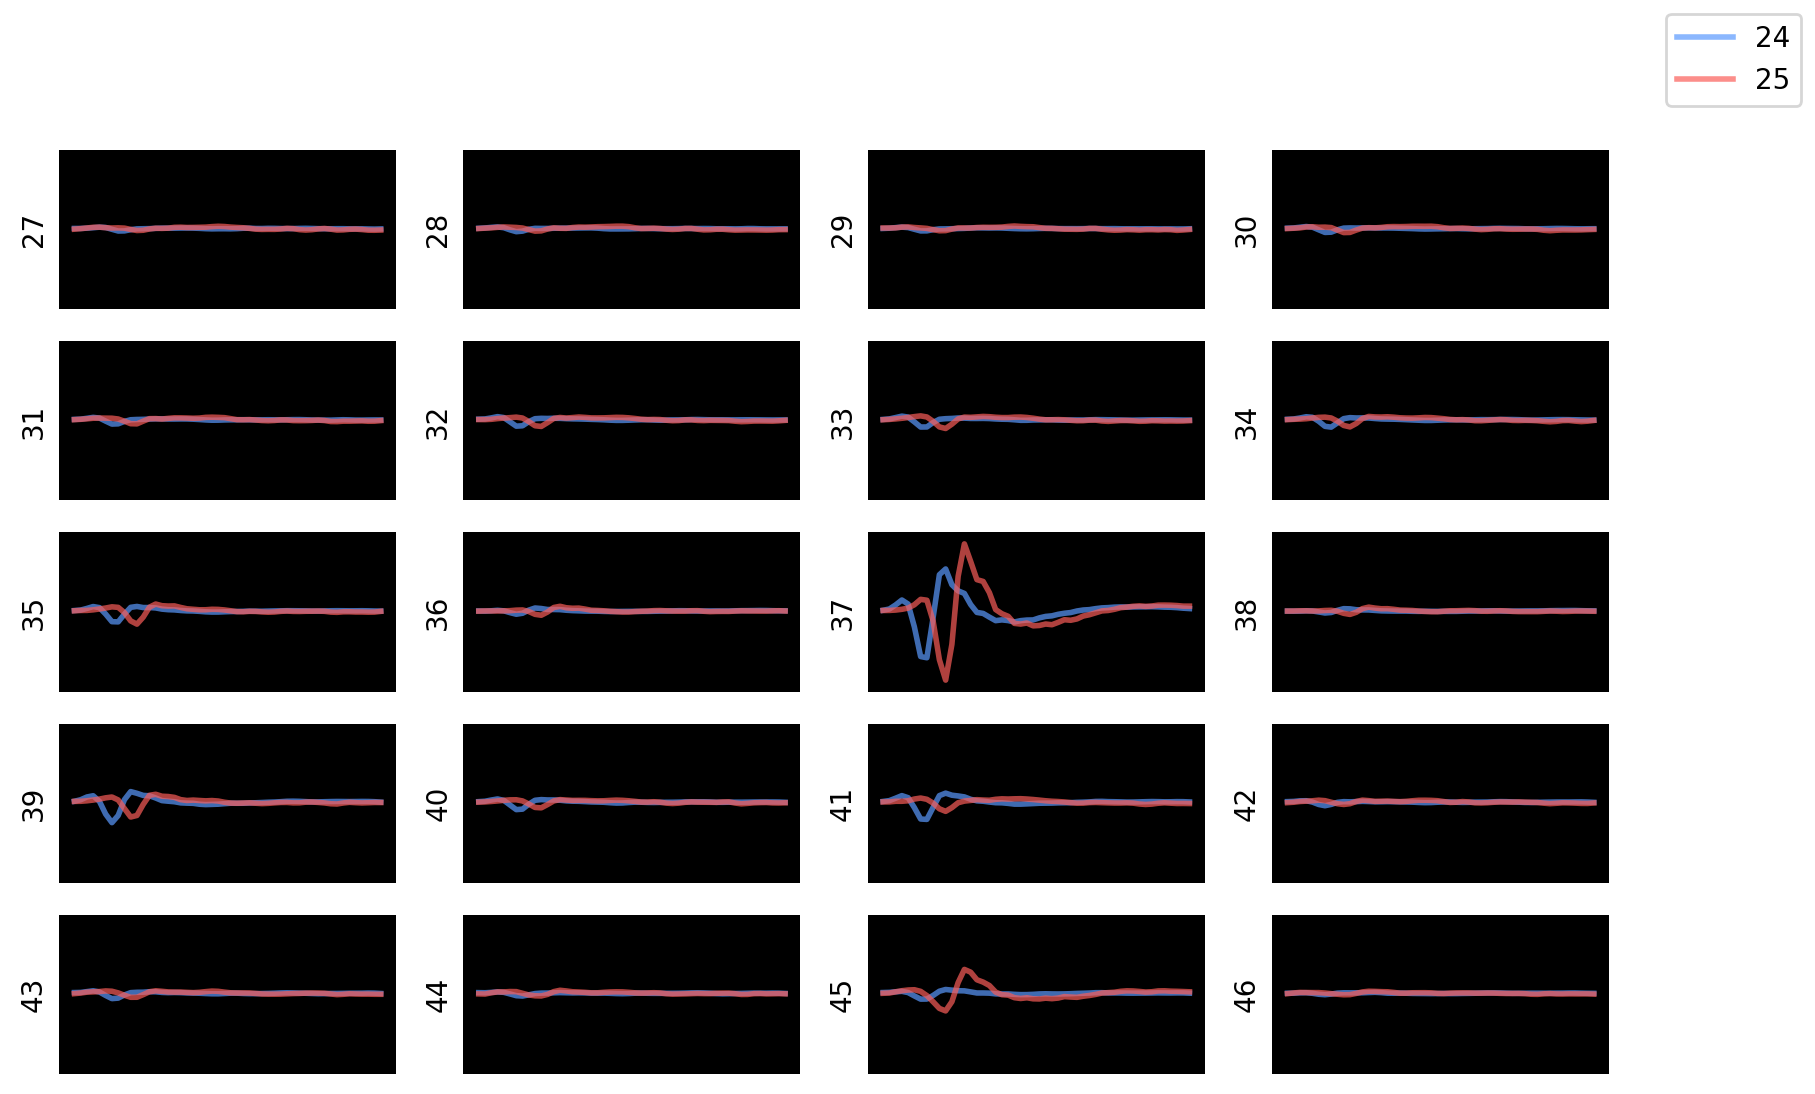

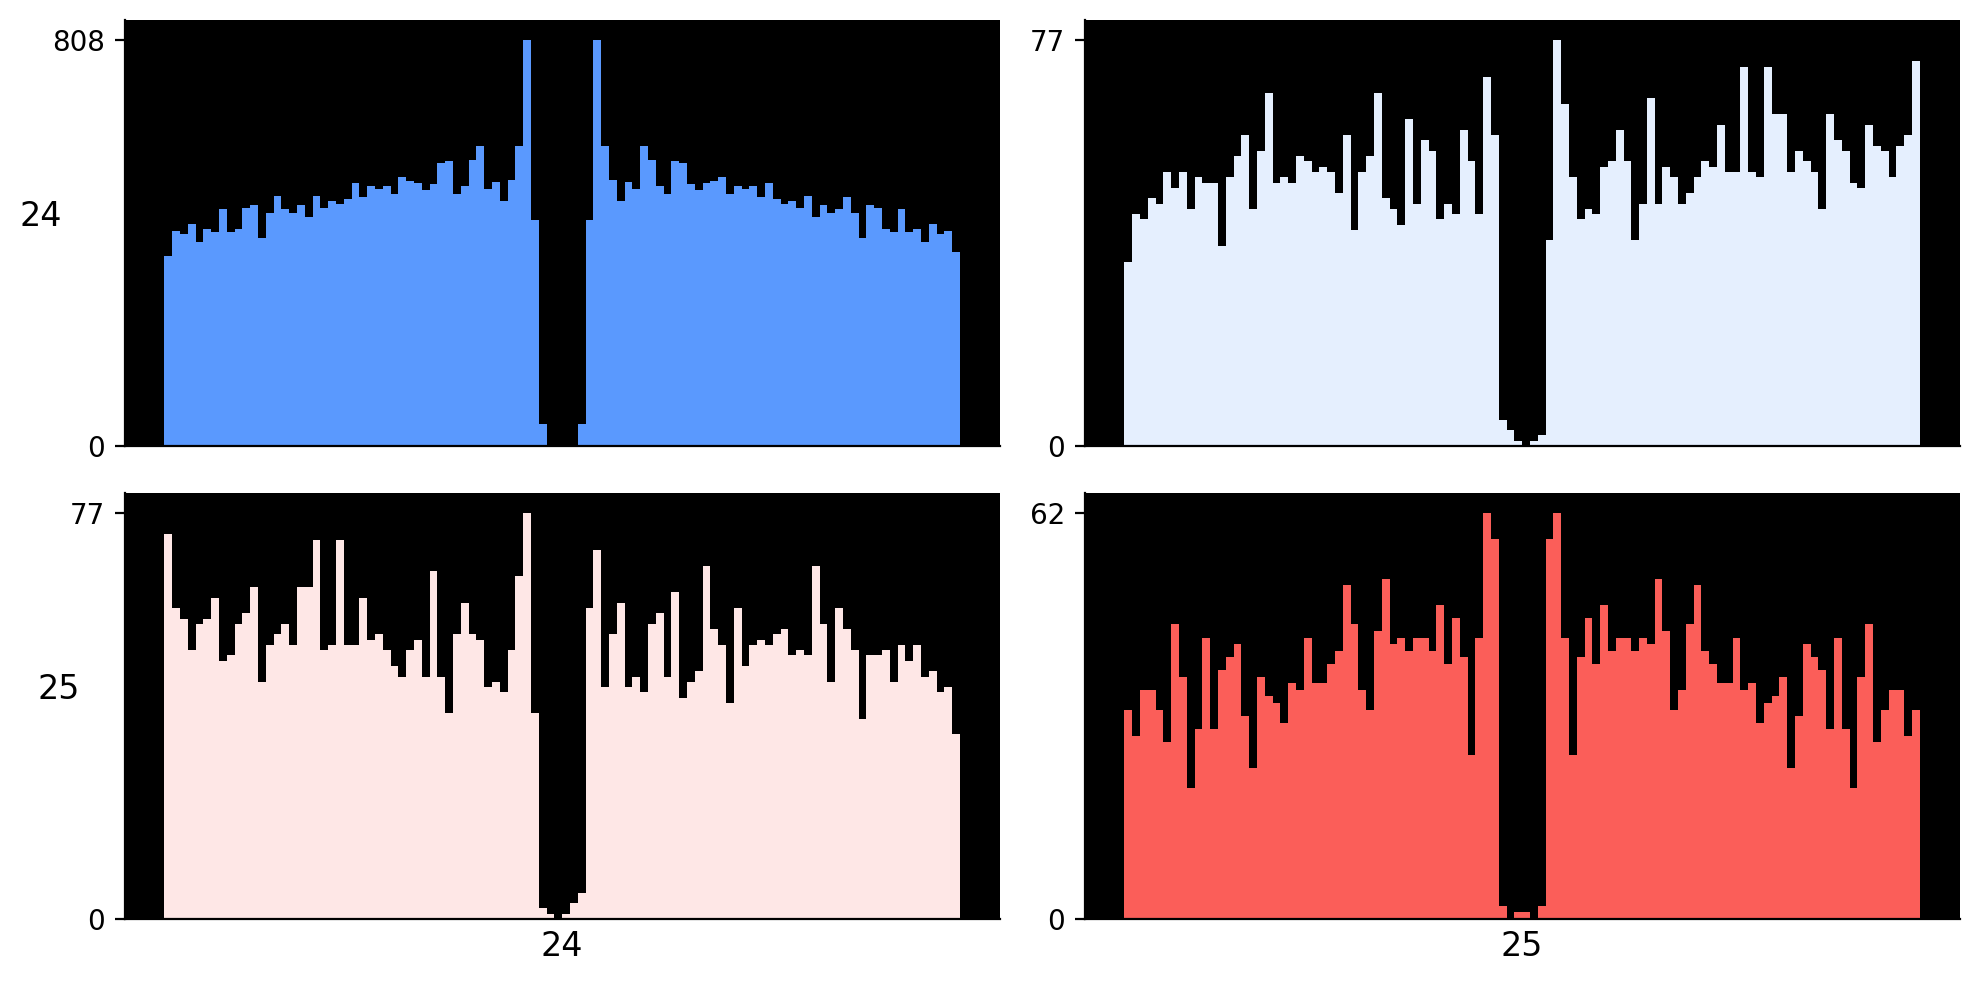

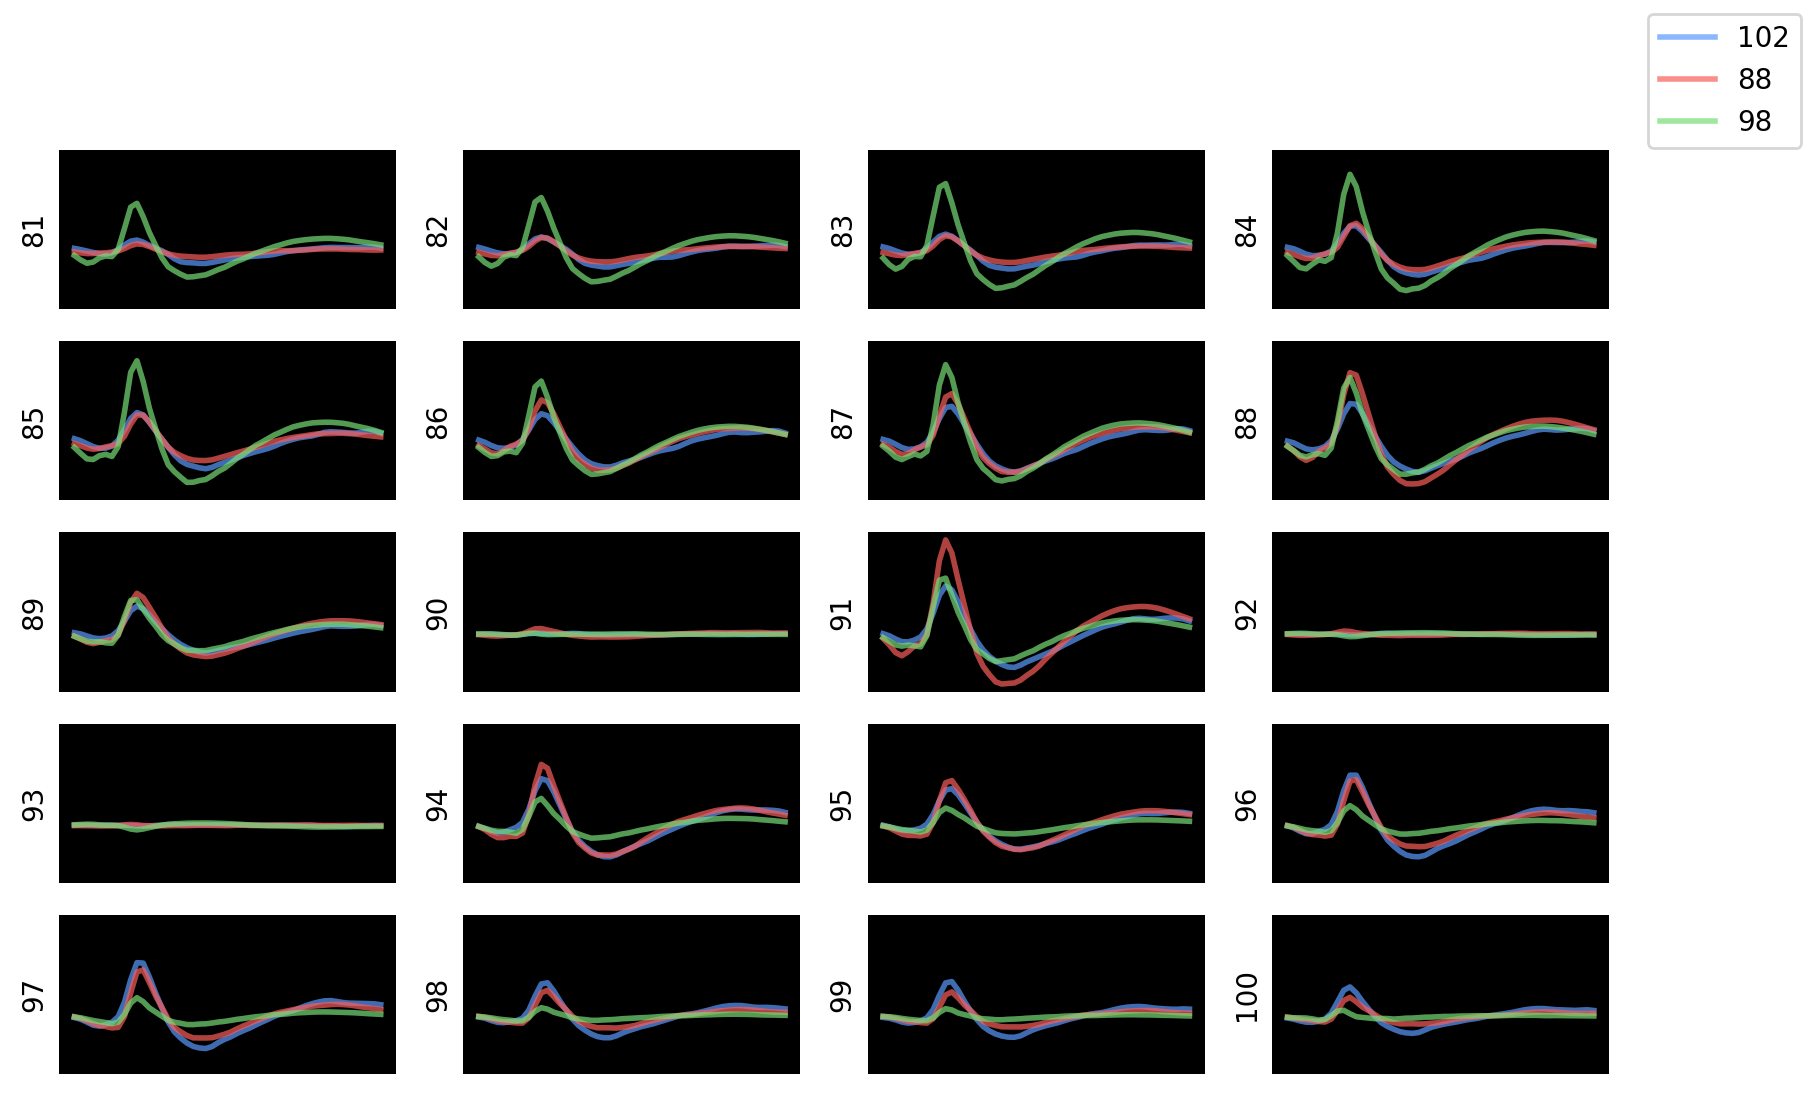

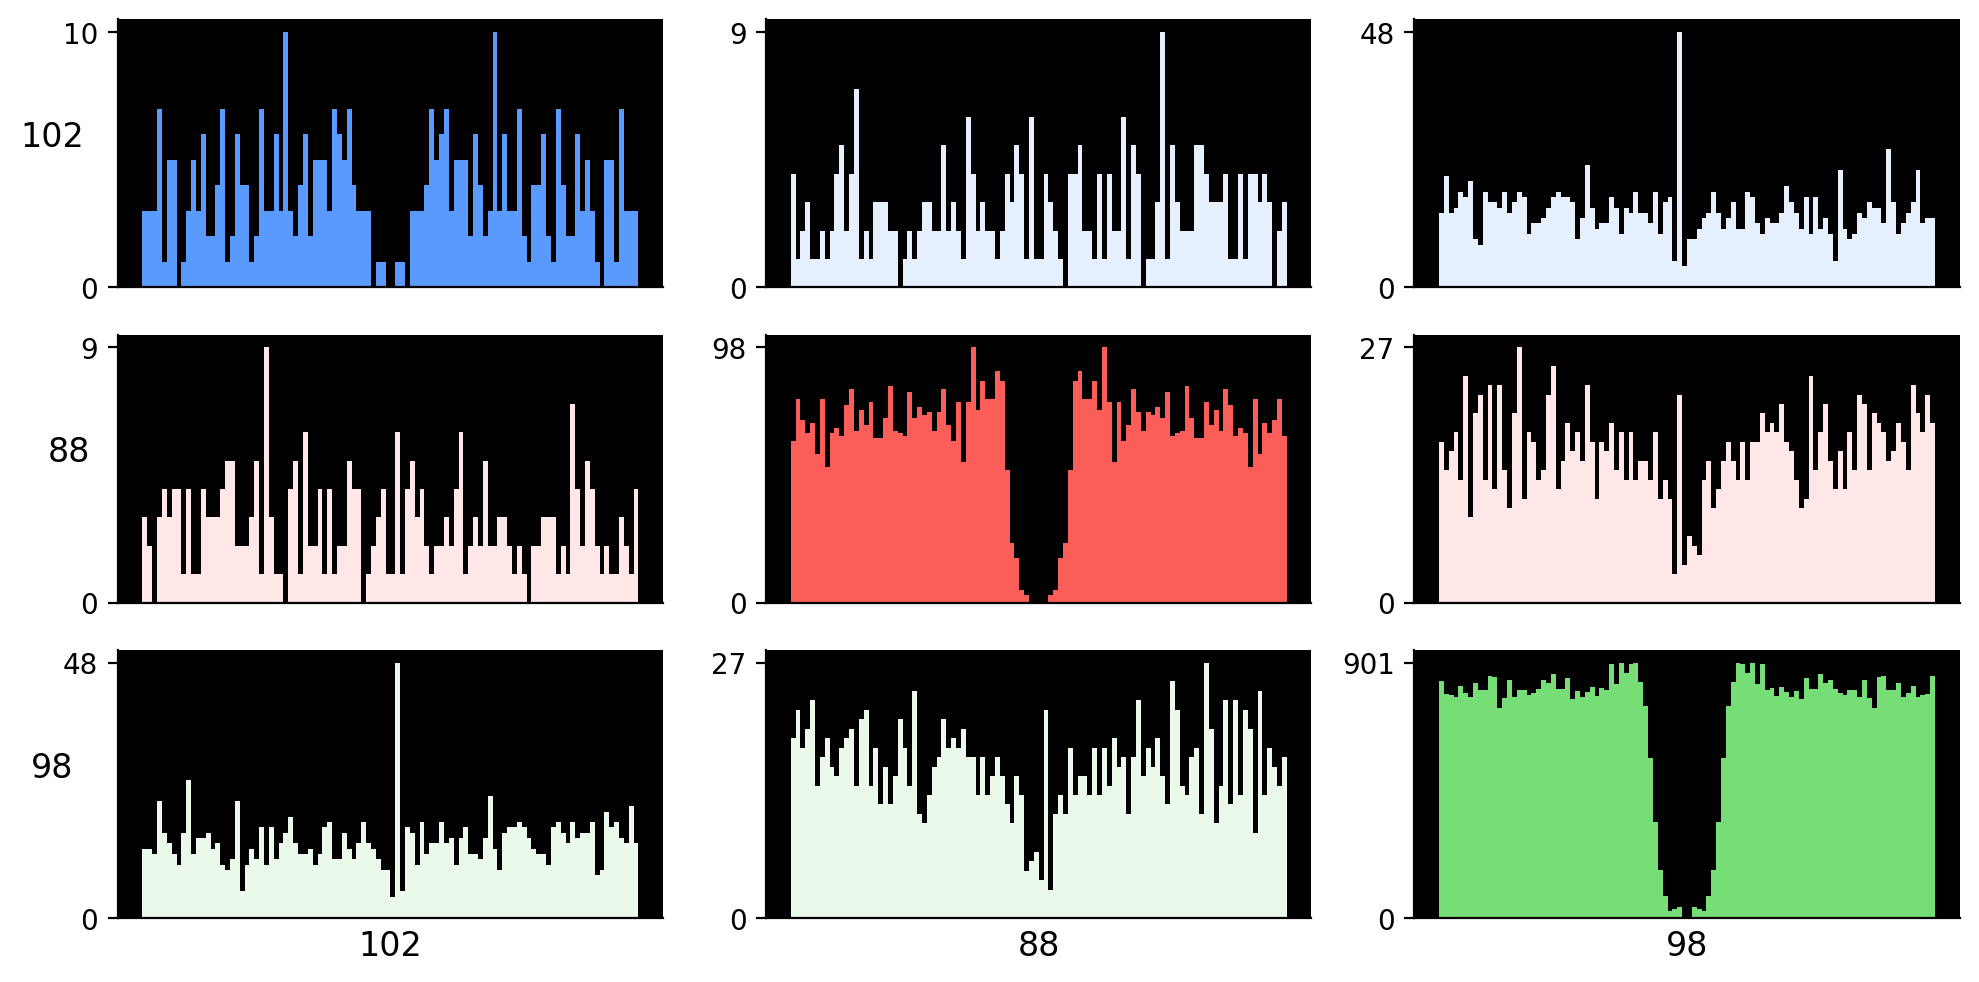

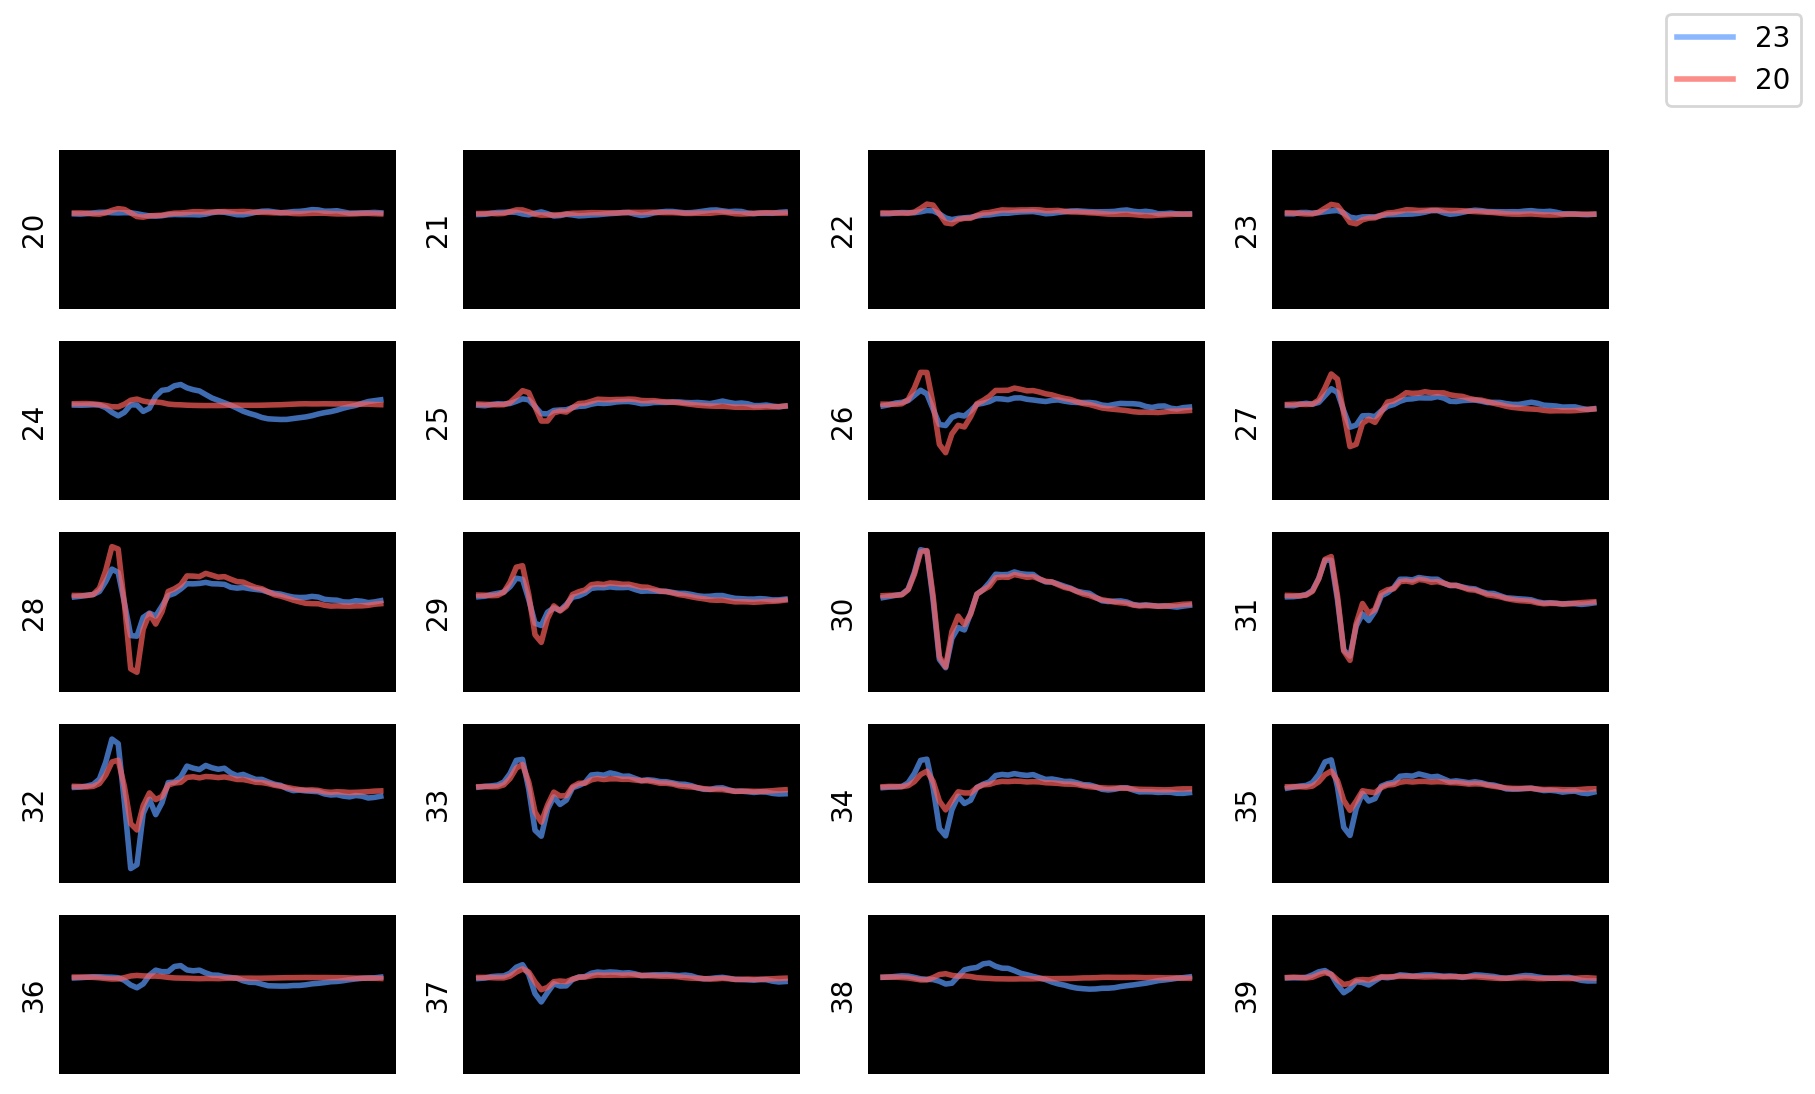

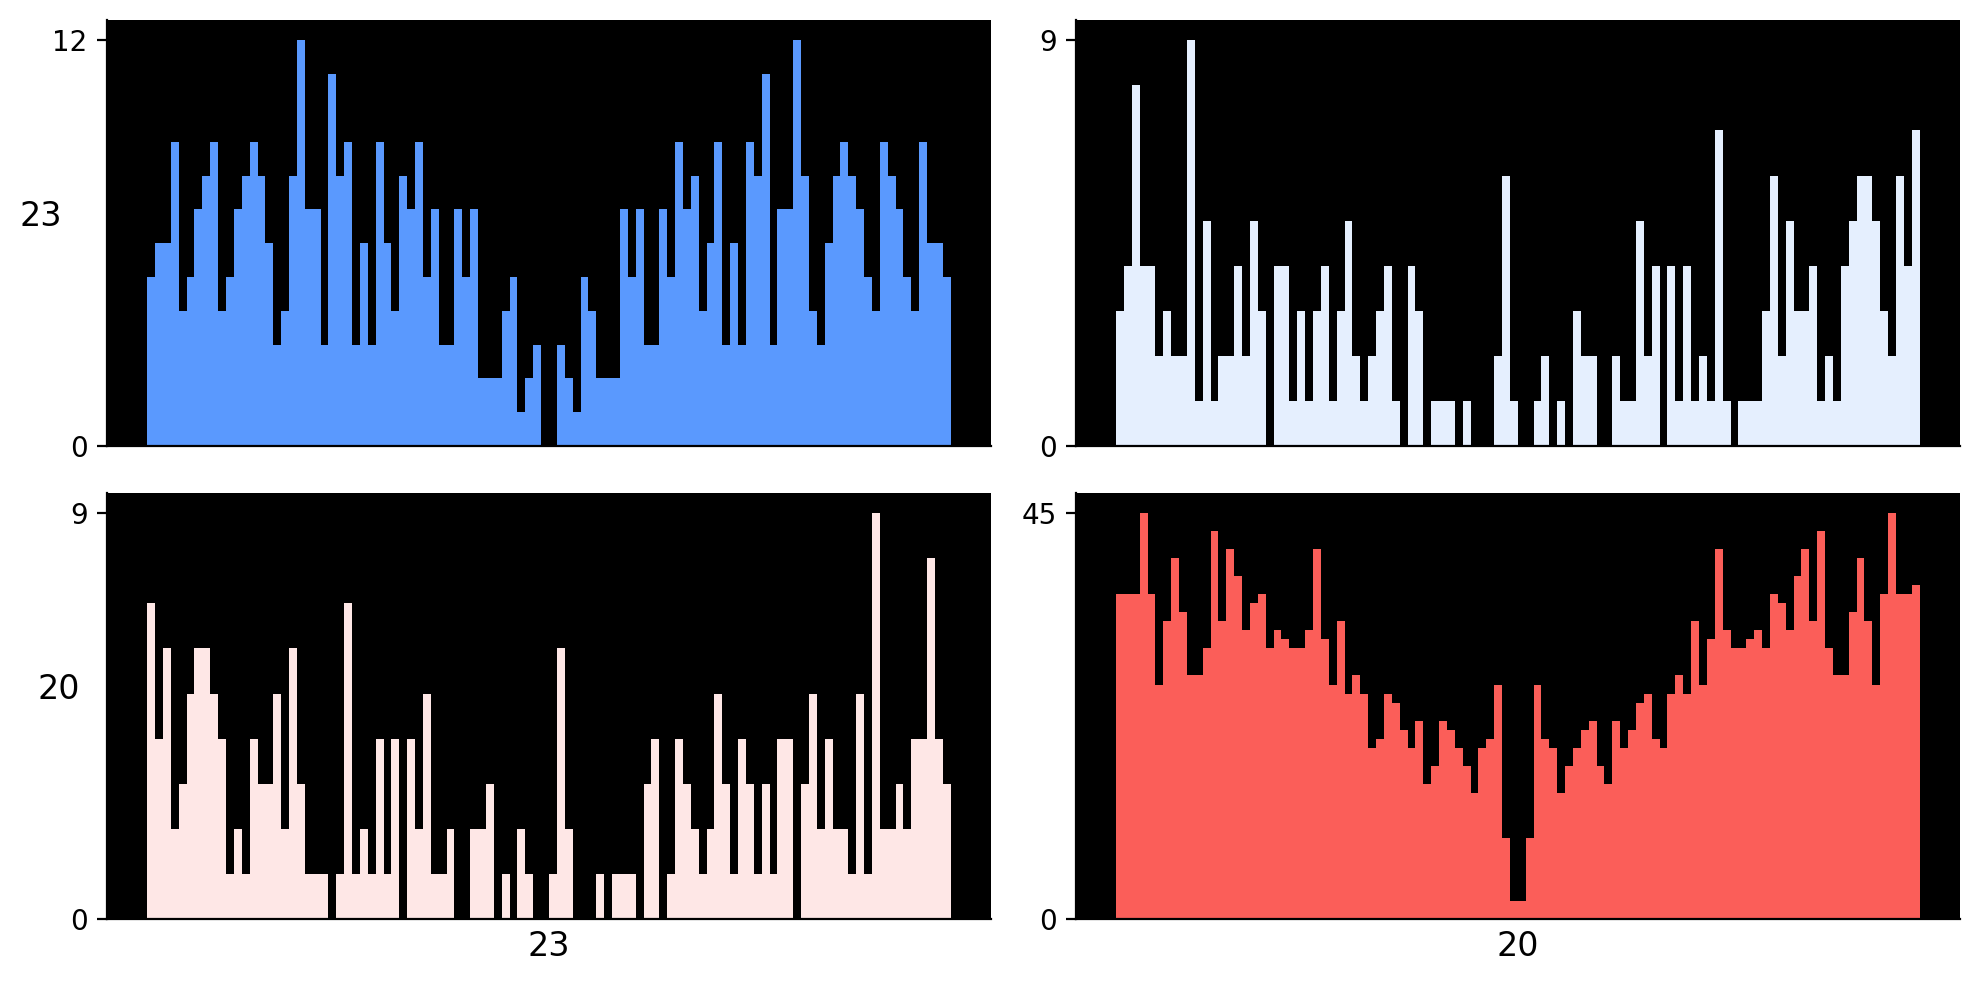

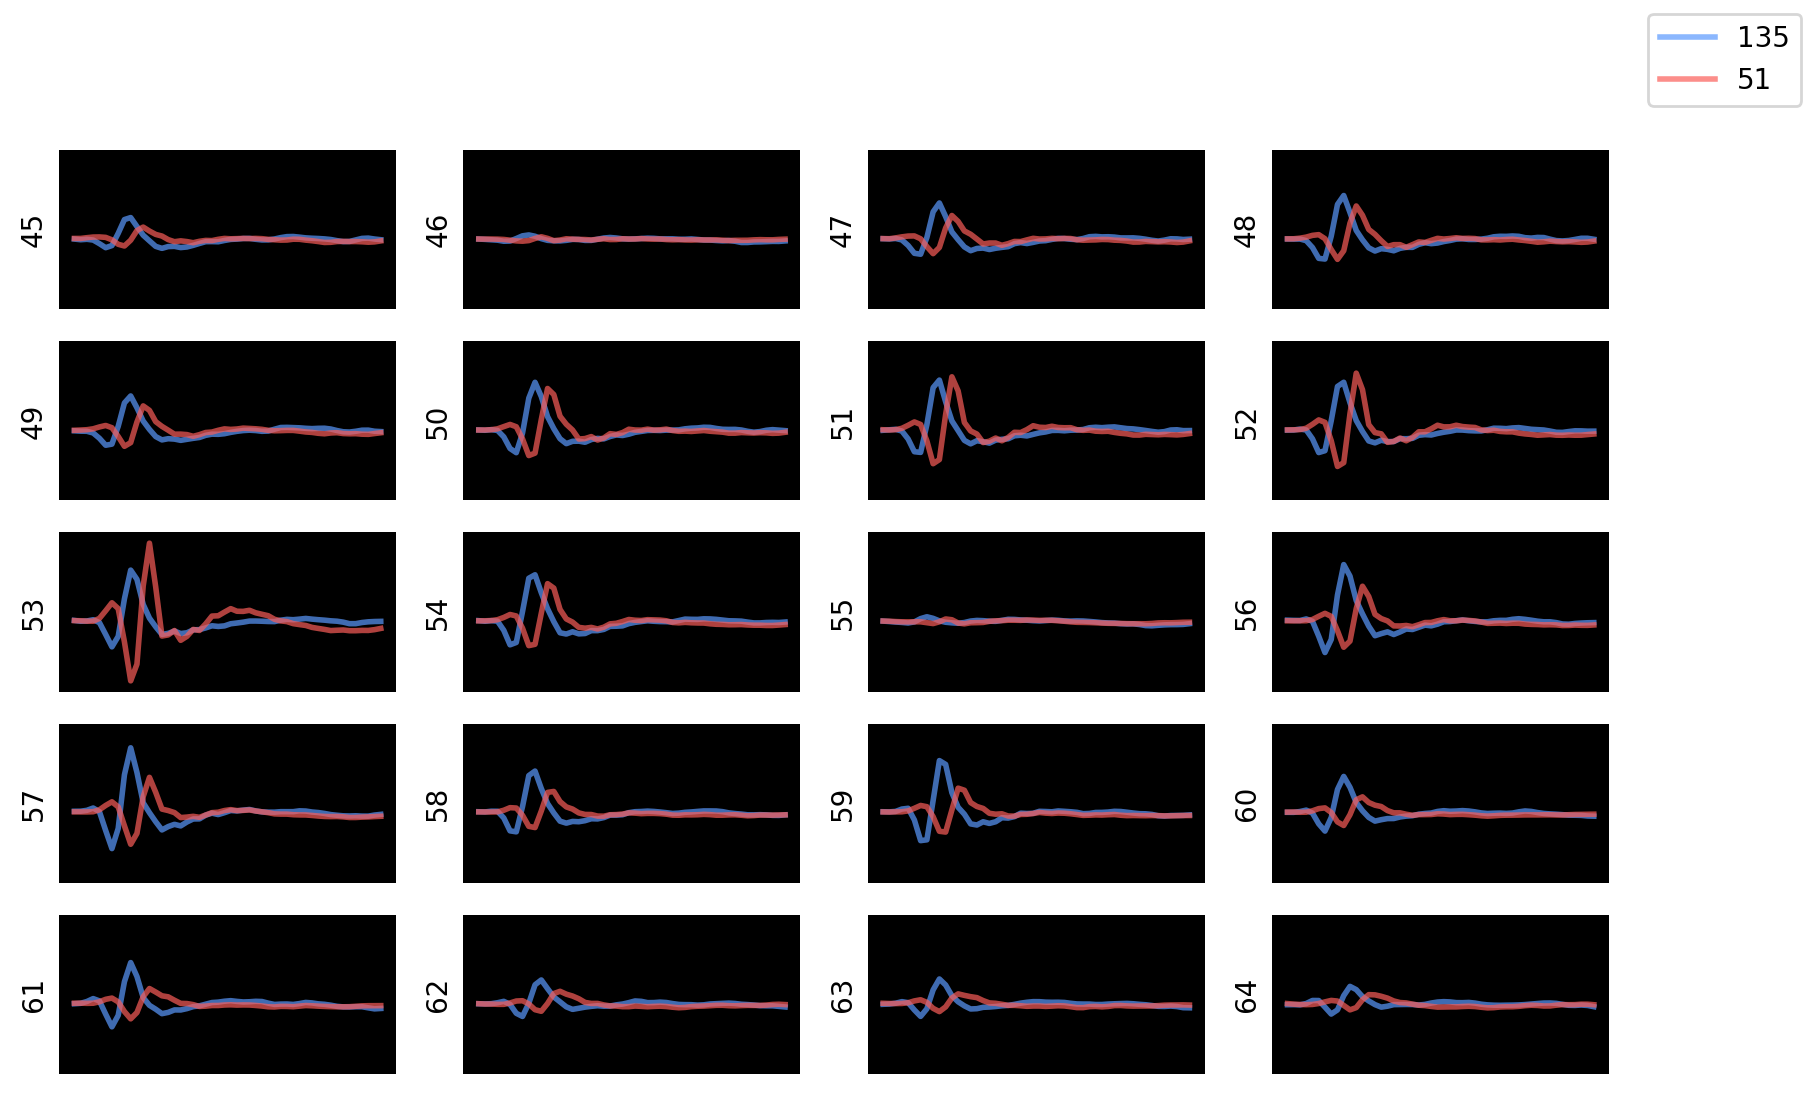

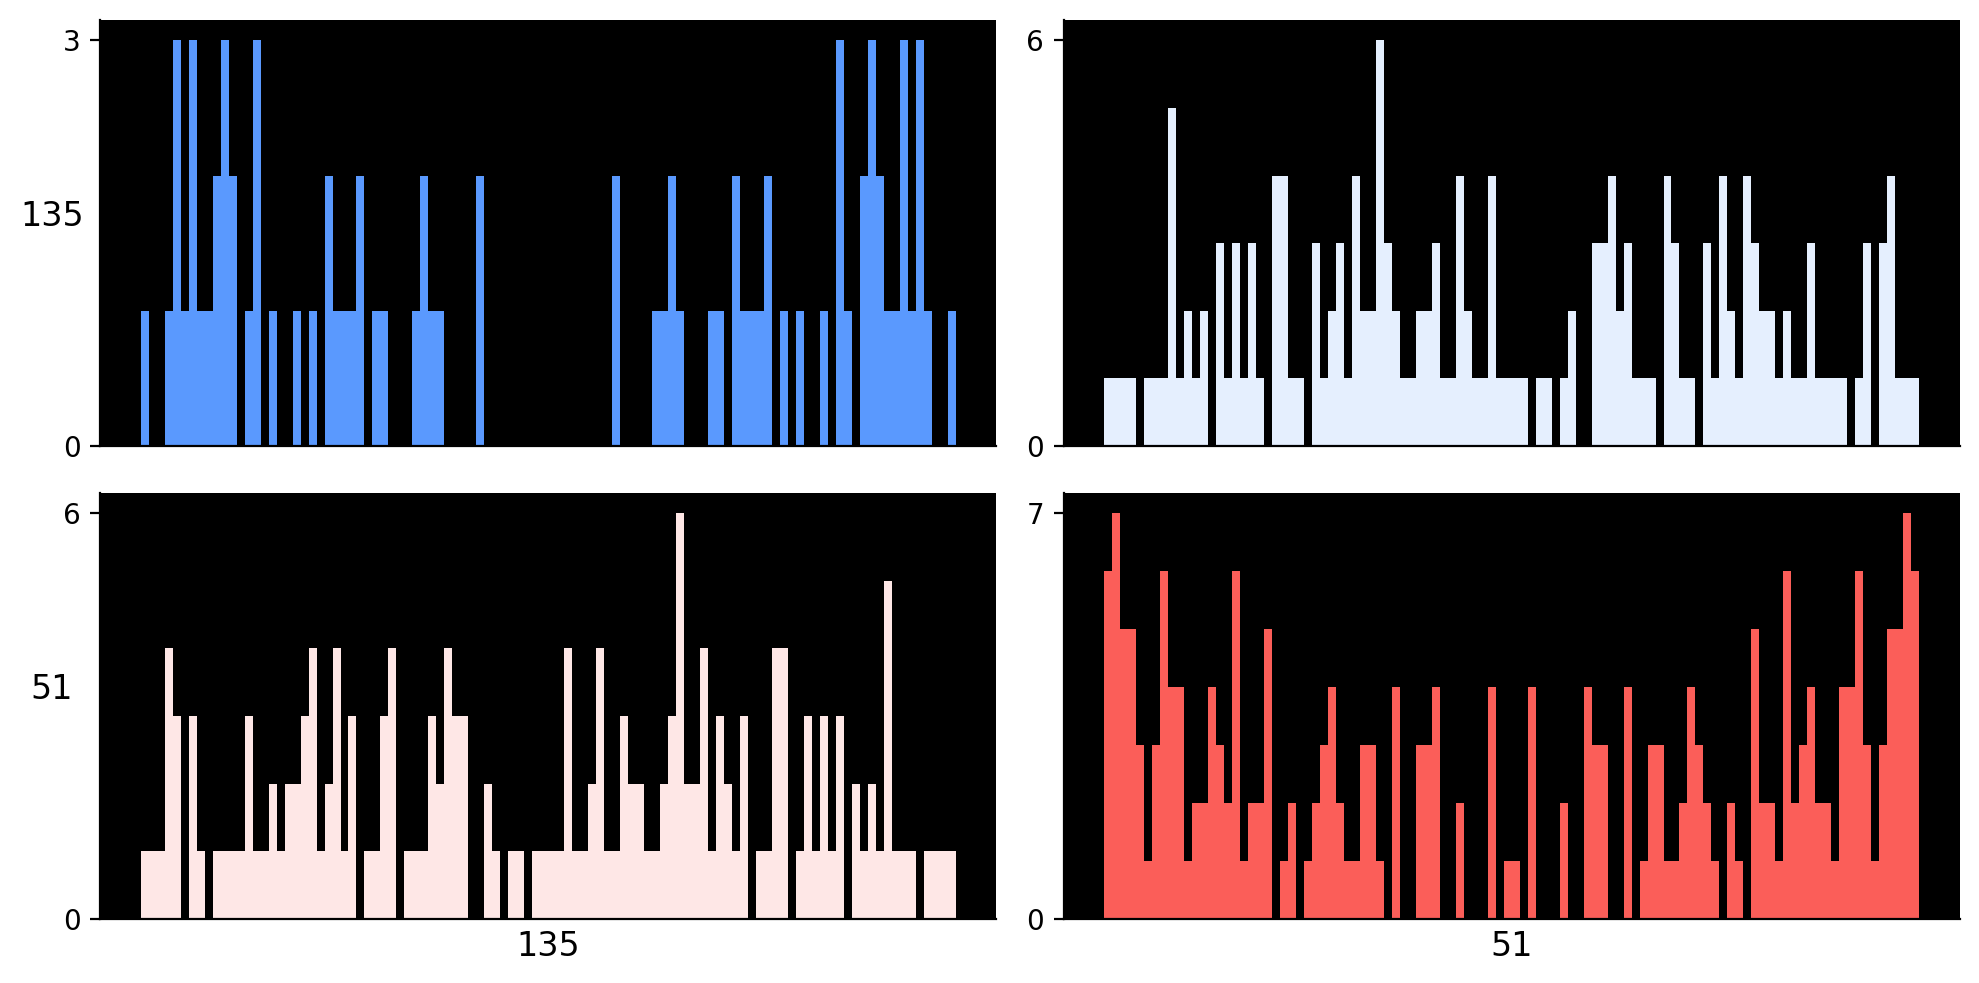

In [12]:
bd.plot.plot_merges(merges, times_multi, mean_wf, params);